# Dynamics of Image Embedding during Evolution w.r.t. reference dataset

In this notebook, we explore how the image embedding of generated images evolved over Evolution, esp. with respect to natural image manifold exemplified by some reference datasets (BigGAN, DeePSim, ImageNet images). 

We are going to compute a batch of statistics for the embedding vector, 
* Mahalanobis distance to the center of an approximated Gaussian distribution
* Negative log likelihood of this sample given a Gaussian approximation to the reference dataset.
* Distance to the nearest neighbor in that dataset. (similar to k-NN density approximation)
* Mahalanobis distance to the nearest neighbor in that dataset. (preconditioning by the eigen spectra of the target dataset.)


## Set up

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import os 
import sys
import glob
import math
import torch
import pickle as pkl
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")

In [2]:
tabdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables"
meta_df = pd.read_csv(join(tabdir, "meta_activation_stats_w_optimizer.csv"), index_col=0)

In [3]:
meta_df.shape

(170, 49)

### Distance and Plot functions

In [4]:
# compute mahalanobis distance
def mahalanobis_sqdist(x, mean, eigvec, eigval, eigfloor=1e-5, device="cuda"):
    x = x.to(device) - mean[None, :].to(device)
    # rotate
    rot_x = x @ eigvec
    # scale
    return (rot_x ** 2 / torch.clamp(eigval[None, :].to(device), min=eigfloor)).sum(dim=1)


# plot functions to collect activation / distace according to gens. 
def compute_mean_var(x, gen_vec, var="std"):
    meanvec = []
    errvec = []
    for gen in range(gen_vec.min(), gen_vec.max()+1):
        meanvec.append(x[gen_vec==gen].mean())
        if var == "std":
            errvec.append(x[gen_vec==gen].std())
        elif var == "var":
            errvec.append(x[gen_vec==gen].var())
        elif var == "sem":
            errvec.append(x[gen_vec==gen].std() / np.sqrt((gen_vec==gen).sum()))
    return torch.tensor(meanvec), torch.tensor(errvec)


def plot_shaded_errorbar(x, y, color="b", label="", var="std", **kwargs):
    meanvec, errvec = compute_mean_var(y, x, var=var)
    plt.plot(np.unique(x), meanvec, color=color, label=label, **kwargs)
    plt.fill_between(np.unique(x), meanvec-errvec, meanvec+errvec, color=color, alpha=0.3)

In [5]:
def gaussian_nll_with_eig(x, mean, eigvals, eigvecs, eigfloor=1E-3, device="cuda"):
    """
    Calculate the Gaussian negative log likelihood of x given the mean, eigenvalues, and eigenvectors.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
        mean (torch.Tensor): Mean tensor of shape (input_dim,).
        eigvals (torch.Tensor): Eigenvalues tensor of shape (input_dim,).
        eigvecs (torch.Tensor): Eigenvectors tensor of shape (input_dim, input_dim).

    Returns:
        torch.Tensor: Gaussian negative log likelihood tensor of shape (batch_size,).
    """
    input_dim = x.size(1)
    diff = x - mean
    eigvals_clamped = torch.clamp(eigvals.to(device), min=eigfloor)
    mahalanobis = torch.matmul(diff, eigvecs)
    mahalanobis = mahalanobis**2 / eigvals_clamped
    mahalanobis = torch.sum(mahalanobis, dim=1)
    log_det = torch.sum(torch.log(eigvals_clamped))
    nll = 0.5 * (input_dim * math.log(2 * math.pi) + log_det + mahalanobis)
    return nll


In [6]:
def dist2k_nearest_neighbor(probe_embed, ref_embed, k_list, device="cuda"):
    """
    Calculate the Euclidean distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    dists = torch.cdist(probe_embed, ref_embed,
                            p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
    max_k = max(k_list)
    k_nearest = torch.topk(dists, max_k, largest=False).values
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances


In [7]:
def dist2k_nearest_neighbor_cosine(probe_embed, ref_embed, k_list, device="cuda"):
    """
    Calculate the 1 - Cosine Similarity distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    similarity = torch.matmul(probe_embed, ref_embed.T)
    similarity = similarity / torch.norm(probe_embed, dim=1)[:, None]
    similarity = similarity / torch.norm(ref_embed, dim=1)[None, :]
    dists = 1 - similarity
    max_k = max(k_list)
    k_nearest = torch.topk(dists, max_k, largest=False).values
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances


In [8]:
def dist2k_nearest_neighbor_mahalanobis(probe_embed, ref_embed, k_list, eigvecs, eigvals, eigfloor=1E-3, device="cuda"):
    """
    Calculate the Euclidean distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    scaling = torch.sqrt(torch.clamp(eigvals.to(device), min=eigfloor))
    probe_embed_rot = (probe_embed @ eigvecs) / scaling
    ref_embed_rot = (ref_embed @ eigvecs) / scaling
    dists = torch.cdist(probe_embed_rot, ref_embed_rot,
                            p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
    max_k = max(k_list)
    k_nearest = torch.topk(dists, max_k, largest=False).values
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances


### Compute Reference Dataset PC structure

In [9]:
GANembed_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_embedding"
GANembed_dir = join(GANembed_root, "dinov2_vitb14")
Evol_embed_dir = '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_img_embedding/dinov2_vitb14'

def load_compute_eigen(dataset_str):
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    embed = embed.cuda()
    cov = torch.cov(embed.T, )
    data_mean = embed.mean(dim=0)
    data_eigvals, data_eigvecs = torch.linalg.eigh(cov)
    data_eigvals = torch.flip(data_eigvals, dims=[0])
    data_eigvecs = torch.flip(data_eigvecs, dims=[1])
    return (data_mean, data_eigvals, data_eigvecs)

def load_dataset_embed(dataset_str):
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    return embed

In [10]:
# FC_mean, FC_eigvals, FC_eigvecs = load_compute_eigen("DeePSim_4std")
# BG_mean, BG_eigvals, BG_eigvecs = load_compute_eigen("BigGAN_trunc07")
# BGRND_mean, BGRND_eigvals, BGRND_eigvecs = load_compute_eigen("BigGAN_std_008")
# IN_mean, IN_eigvals, IN_eigvecs = load_compute_eigen("imagenet_valid")
MH_eig_col = {}
for dataset_str in [
    "DeePSim_4std",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "imagenet_valid",
    'ecoset_val',
    'places365_val',
    'massmem_objects',
    'curvature_contour',
    "pink_noise",
]:
    MH_eig_col[dataset_str] = load_compute_eigen(dataset_str)

In [11]:
dataset_embed_col = {}
for dataset_str in [
    "DeePSim_4std",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "imagenet_valid",
    'ecoset_val',
    'places365_val',
    'massmem_objects',
    'curvature_contour',
    "pink_noise",
]:
    dataset_embed_col[dataset_str] = load_dataset_embed(dataset_str).cuda()

## Dataset distance dist. baselines

Compute the baseline distance structure between the reference dataset samples.

Generally there are two types of metrics, local distance measures or global distance measures
* **Global distance**: NLL & MHdistance are assuming the whole point cloud is Multivariate Gaussian, then evaluate the distance to the distribution center considering the Gaussian covariance.
* **Local distance**: KNN and MHKnn are local measures, considering the distance to the nearest points in the reference dataset. kNN assume isotropy in the embedding space; Mahalanobis kNN assumes the embedding space has the geometry defined by the global covariance of the Gaussian. 

In [14]:
# baselines 
df_col = []
for baseline_str in dataset_embed_col:
    # embeddings from the baseline dataset
    embeddings_ref = load_dataset_embed(baseline_str)
    for dataset_str in MH_eig_col:
        # compute distance to the PCdataset based on PC of the PCdataset 
        data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
        dataset_embed = load_dataset_embed(dataset_str)
        MHdist_ref = mahalanobis_sqdist(embeddings_ref.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
        kNNdist_ref = dist2k_nearest_neighbor(embeddings_ref, dataset_embed, k_list=[1, 5, 10, 25, 50])
        kNNMHdist_ref = dist2k_nearest_neighbor_mahalanobis(embeddings_ref, dataset_embed, [1, 5, 10, 25, 50],
                                                            data_eigvecs, data_eigvals, eigfloor=1e-3)
        kNNcosdist_ref = dist2k_nearest_neighbor_cosine(embeddings_ref, dataset_embed, [1, 5, 10, 25, 50])
        ref_dist_col = {}
        ref_dist_col["baseline"] = baseline_str
        ref_dist_col["PC_dataset"] = dataset_str
        ref_dist_col["MHdist"] = MHdist_ref.numpy()
        for k in kNNdist_ref:
            ref_dist_col[f"kNNdist_{k}"] = kNNdist_ref[k].cpu().numpy()
            ref_dist_col[f"kNNMHdist_{k}"] = kNNMHdist_ref[k].cpu().numpy()
            ref_dist_col[f"kNNcosdist_{k}"] = kNNcosdist_ref[k].cpu().numpy()
        df = pd.DataFrame(ref_dist_col)
        df_col.append(df)
df_total = pd.concat(df_col, ignore_index=True)

In [15]:
df_total.to_csv(join(tabdir, "reference_dataset_DINO_embed_MHdist_all.csv"))

<Axes: xlabel='PC_dataset', ylabel='kNNMHdist_25'>

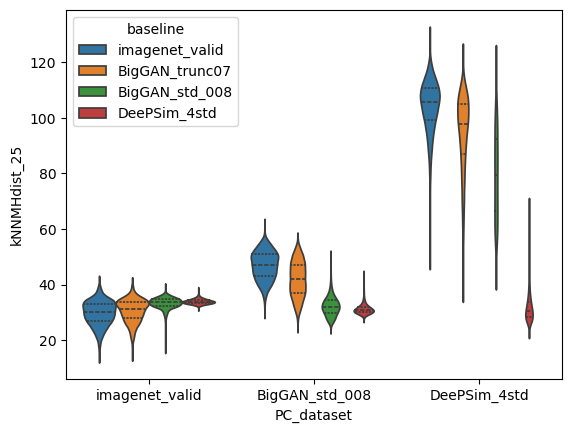

In [83]:
sns.violinplot(data=df_total, x="PC_dataset", y="kNNMHdist_25", hue="baseline", 
               order=["imagenet_valid", "BigGAN_std_008", "DeePSim_4std"], #"BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"
               hue_order=["imagenet_valid", "BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"],
               split=False, inner="quartile")

<Axes: xlabel='PC_dataset', ylabel='kNNdist_25'>

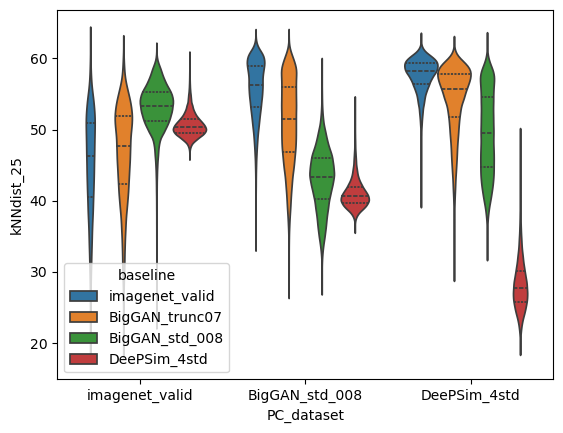

In [105]:
sns.violinplot(data=df_total, x="PC_dataset", y="kNNdist_25", hue="baseline", 
               order=["imagenet_valid", "BigGAN_std_008", "DeePSim_4std"], #"BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"
               hue_order=["imagenet_valid", "BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"],
               split=False, inner="quartile")

<Axes: xlabel='PC_dataset', ylabel='kNNMHdist_50'>

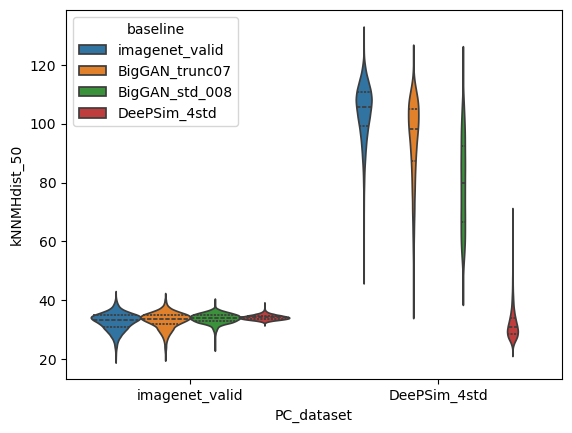

In [94]:
sns.violinplot(data=df_total, x="PC_dataset", y="kNNMHdist_50", hue="baseline", 
               order=["imagenet_valid", "DeePSim_4std"], 
               hue_order=["imagenet_valid", "BigGAN_trunc07", "BigGAN_std_008", "DeePSim_4std"],
               split=False, inner="quartile")

In [95]:
df_total.groupby(["baseline", "PC_dataset"], sort=False).mean()

MHdist  kNNdist_1  kNNMHdist_1  \
baseline       PC_dataset                                             
imagenet_valid imagenet_valid  7.669849e+02   0.017555     0.010559   
               BigGAN_trunc07  1.172249e+03  41.033138    31.475887   
               BigGAN_std_008  1.992977e+03  49.404121    43.495720   
               DeePSim_4std    1.097895e+04  55.930874   102.249161   
               pink_noise      1.161598e+06  64.253807  1070.472900   
BigGAN_trunc07 imagenet_valid  7.754193e+02  39.196125    26.173273   
               BigGAN_trunc07  7.669850e+02   0.017349     0.010534   
               BigGAN_std_008  1.556016e+03  42.912834    37.480881   
               DeePSim_4std    9.144888e+03  52.322266    92.793991   
               pink_noise      1.106762e+06  62.868679  1043.611206   
BigGAN_std_008 imagenet_valid  7.466710e+02  48.583401    31.180338   
               BigGAN_trunc07  7.631931e+02  42.356819    30.289633   
               BigGAN_std_008  7.669850e+02   0.016654     0.010683   
               DeePSim_4std    6.490394e+03  47.744808    78.554764   
               pink_noise      1.037901e+06  60.978539  1010.014465   
DeePSim_4std   imagenet_valid  7.369121e+02  46.615810    31.912107   
               BigGAN_trunc07  5.616245e+02  37.310741    27.172159   
               BigGAN_std_008  6.894410e+02  38.095329    29.843237   
               DeePSim_4std    7.669851e+02   0.014703     0.015863   
               pink_noise      6.013430e+05  51.004421   766.210510   

                               kNNdist_5  kNNMHdist_5  kNNdist_10  \
baseline       PC_dataset                                           
imagenet_valid imagenet_valid  38.101162    25.442848   40.784283   
               BigGAN_trunc07  43.614735    33.220684   44.949841   
               BigGAN_std_008  52.841801    45.603081   54.132050   
               DeePSim_4std    56.949856   103.548286   57.274326   
               pink_noise      64.807198  1072.153198   65.045868   
BigGAN_trunc07 imagenet_valid  42.002735    27.875862   43.555843   
               BigGAN_trunc07  32.324566    24.654257   34.126831   
               BigGAN_std_008  47.293892    40.265949   48.973789   
               DeePSim_4std    53.456848    94.058533   53.817829   
               pink_noise      63.464512  1045.510620   63.734211   
BigGAN_std_008 imagenet_valid  50.764118    32.284691   51.712635   
               BigGAN_trunc07  44.562634    31.454437   45.528503   
               BigGAN_std_008  39.927792    30.995407   41.303356   
               DeePSim_4std    48.759541    79.218651   49.115929   
               pink_noise      61.655945  1012.079224   62.006149   
DeePSim_4std   imagenet_valid  48.554298    32.924831   49.410809   
               BigGAN_trunc07  39.270988    28.166845   40.043724   
               BigGAN_std_008  39.587708    30.482096   40.205173   
               DeePSim_4std    27.198690    31.021587   27.638178   
               pink_noise      51.983284   768.548401   52.418655   

                               kNNMHdist_10  kNNdist_25  kNNMHdist_25  \
baseline       PC_dataset                                               
imagenet_valid imagenet_valid     27.067245   45.307720     29.706253   
               BigGAN_trunc07     34.096268   47.397259     35.637627   
               BigGAN_std_008     46.248524   55.702541     46.898819   
               DeePSim_4std      103.888123   57.664635    104.237587   
               pink_noise       1072.656738   65.287643   1073.220459   
BigGAN_trunc07 imagenet_valid     28.801477   46.730324     30.638498   
               BigGAN_trunc07     25.865746   37.353352     27.952417   
               BigGAN_std_008     41.117004   51.050056     41.948715   
               DeePSim_4std       94.378403   54.261181     94.716660   
               pink_noise       1046.036499   63.993126   1046.613892   
BigGAN_std_008 imagenet_valid     32.737179   53.128880     33.376690   
      

## Massive Compute 

Compute the distance of evolved images to different reference dataset and with various measures.

In [17]:
# compute mahalanobis distance for all Exps
stats_df_col = []
for Expi in tqdm(range(1, 190+1)):
    # if ~ os.path.exists(join(Evol_embed_dir, f"Exp{Expi}_embed_act_data.pkl")):
    #     continue
    if Expi not in meta_df.index:
        continue
    meta_dict = meta_df.loc[Expi][['Animal', 'expdate', 'ephysFN', 'prefchan', 'prefunit', 'visual_area',
       'space1', 'space2', 'optim_names1', 'optim_names2', 'blockN']].to_dict()
    Evol_data = pkl.load(open(join(Evol_embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "rb"))
    for thread in [0, 1]:
        stats_col = {}
        embeddings = Evol_data[f"embeddings{thread}"].cuda()
        gen_vec = Evol_data[f"gen_vec{thread}"]
        resp_mat = Evol_data[f"resp_mat{thread}"]
        stats_col["Expi"] = Expi
        stats_col["thread"] = thread
        stats_col["generation"] = gen_vec
        stats_col["resp_mean"] = resp_mat[:, 0]
        for dataset_str in MH_eig_col:
            data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
            dataset_embed = dataset_embed_col[dataset_str]
            MHdist_thread = mahalanobis_sqdist(embeddings, data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
            NLL_thread = gaussian_nll_with_eig(embeddings, data_mean, data_eigvals, data_eigvecs, eigfloor=1e-3).cpu()
            kNNdist = dist2k_nearest_neighbor(embeddings, dataset_embed, k_list=[1, 5, 10, 25, 50])
            KNNMHdist = dist2k_nearest_neighbor_mahalanobis(embeddings, dataset_embed, [1, 5, 10, 25, 50],
                                                            data_eigvecs, data_eigvals, eigfloor=1e-3)
            kNNcosdist = dist2k_nearest_neighbor_cosine(embeddings, dataset_embed, [1, 5, 10, 25, 50])
            stats_col[f"MHdist_{dataset_str}"] = MHdist_thread
            stats_col[f"NLL_{dataset_str}"] = NLL_thread
            for k in kNNdist:
                stats_col[f"kNNdist_{k}_{dataset_str}"] = kNNdist[k].cpu()
                stats_col[f"kNNMHdist_{k}_{dataset_str}"] = KNNMHdist[k].cpu()
                stats_col[f"kNNcosdist_{k}_{dataset_str}"] = kNNcosdist[k].cpu()
        stats_col.update(meta_dict)
        stats_df = pd.DataFrame(stats_col)
        stats_df_col.append(stats_df)
    # raise RuntimeError("Stop here")
stats_df_all = pd.concat(stats_df_col, ignore_index=True)

  0%|          | 0/190 [00:00<?, ?it/s]

100%|██████████| 190/190 [00:54<00:00,  3.51it/s]


In [18]:
stats_df_all.to_csv(join(tabdir, "Evol_img_DINO_embed_MHdist_all.csv"))

In [86]:
stats_df_all.columns

Index(['Expi', 'thread', 'generation', 'resp_mean', 'MHdist_imagenet_valid',
       'NLL_imagenet_valid', 'kNNdist_1_imagenet_valid',
       'kNNMHdist_1_imagenet_valid', 'kNNdist_5_imagenet_valid',
       'kNNMHdist_5_imagenet_valid', 'kNNdist_10_imagenet_valid',
       'kNNMHdist_10_imagenet_valid', 'kNNdist_25_imagenet_valid',
       'kNNMHdist_25_imagenet_valid', 'kNNdist_50_imagenet_valid',
       'kNNMHdist_50_imagenet_valid', 'MHdist_BigGAN_trunc07',
       'NLL_BigGAN_trunc07', 'kNNdist_1_BigGAN_trunc07',
       'kNNMHdist_1_BigGAN_trunc07', 'kNNdist_5_BigGAN_trunc07',
       'kNNMHdist_5_BigGAN_trunc07', 'kNNdist_10_BigGAN_trunc07',
       'kNNMHdist_10_BigGAN_trunc07', 'kNNdist_25_BigGAN_trunc07',
       'kNNMHdist_25_BigGAN_trunc07', 'kNNdist_50_BigGAN_trunc07',
       'kNNMHdist_50_BigGAN_trunc07', 'MHdist_BigGAN_std_008',
       'NLL_BigGAN_std_008', 'kNNdist_1_BigGAN_std_008',
       'kNNMHdist_1_BigGAN_std_008', 'kNNdist_5_BigGAN_std_008',
       'kNNMHdist_5_BigGAN_std_

## PostHoc All Session Synopsis

### Loading precomputed data

In [12]:
stats_df_all = pd.read_csv(join(tabdir, "Evol_img_DINO_embed_MHdist_all.csv"), index_col=0)
ref_df_all  = pd.read_csv(join(tabdir, "reference_dataset_DINO_embed_MHdist_all.csv"), index_col=0)

In [15]:
stats_df_all.head()

Expi  thread  generation   resp_mean  MHdist_DeePSim_4std  \
0     3       0           1  159.850917           2023.48280   
1     3       0           1  105.139166            475.57220   
2     3       0           1  114.781936            661.42180   
3     3       0           1  113.217269            649.97253   
4     3       0           1  204.278660           1743.67440   

   NLL_DeePSim_4std  kNNdist_1_DeePSim_4std  kNNMHdist_1_DeePSim_4std  \
0         1295.3003               34.722015                 46.842390   
1          521.3450               23.201656                 25.381382   
2          614.2698               24.163485                 29.427334   
3          608.5451               25.696388                 29.336214   
4         1155.3960               35.117172                 43.873980   

   kNNdist_5_DeePSim_4std  kNNMHdist_5_DeePSim_4std  ...     expdate  \
0               35.317677                 47.170390  ...  2020-07-22   
1               23.972368                 26.260760  ...  2020-07-22   
2               25.204218                 29.925085  ...  2020-07-22   
3               26.010735                 29.685272  ...  2020-07-22   
4               35.784576                 44.154106  ...  2020-07-22   

             ephysFN  prefchan  prefunit  visual_area  space1        space2  \
0  Beto-22072020-002         5         2           IT     fc6  BigGAN_class   
1  Beto-22072020-002         5         2           IT     fc6  BigGAN_class   
2  Beto-22072020-002         5         2           IT     fc6  BigGAN_class   
3  Beto-22072020-002         5         2           IT     fc6  BigGAN_class   
4  Beto-22072020-002         5         2           IT     fc6  BigGAN_class   

   optim_names1  optim_names2  blockN  
0         CMAES         CMAES      47  
1         CMAES         CMAES      47  
2         CMAES         CMAES      47  
3         CMAES         CMAES      47  
4         CMAES         CMAES      47  

[5 rows x 123 columns]

### Get Session Masks

In [13]:
from neuro_data_analysis.neural_data_utils import get_all_masks
Amsk, Bmsk, V1msk, V4msk, ITmsk, length_msk, spc_msk, \
    sucsmsk, bsl_unstable_msk, bsl_stable_msk, validmsk = get_all_masks(meta_df)
mask_dict = get_all_masks(meta_df, return_type=dict)
FCsucs_msk = meta_df.p_maxinit_0 < 0.05 
BGsucs_msk = meta_df.p_maxinit_1 < 0.05
bothsucs_msk = FCsucs_msk & BGsucs_msk
anysucs_msk = FCsucs_msk | BGsucs_msk

total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3
total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3


In [ ]:
init_gen_mask  = (stats_df_all.generation > 1) & \
                 (stats_df_all.generation <= 5)
final_gen_mask = (stats_df_all.generation >= stats_df_all.blockN - 5) & \
                 (stats_df_all.generation <= stats_df_all.blockN - 1)

### Rough GroupBy Stats 

In [50]:
stats_df_all.groupby(["visual_area", "thread"])[["NLL_DeePSim_4std", 
                                                "NLL_BigGAN_trunc07", 
                                                "NLL_BigGAN_std_008", 
                                                "NLL_imagenet_valid"]].mean()

NLL_DeePSim_4std  NLL_BigGAN_trunc07  NLL_BigGAN_std_008  \
visual_area thread                                                             
IT          0             907.389709         1228.193726         1152.252441   
            1            4115.888672         1326.638184         1264.182373   
V1          0             840.587769         1224.839966         1149.420288   
            1            3013.536133         1277.641968         1203.742798   
V4          0             843.243164         1226.365112         1153.213867   
            1            3234.308838         1289.146118         1217.587646   

                    NLL_imagenet_valid  
visual_area thread                      
IT          0              1393.744385  
            1              1389.596436  
V1          0              1394.820435  
            1              1375.331543  
V4          0              1394.499512  
            1              1379.713745

In [51]:
stats_df_all[stats_df_all.Expi.isin(meta_df[validmsk & bothsucs_msk].index)].\
            groupby(["visual_area", "thread"])[["NLL_DeePSim_4std", 
                                                "NLL_BigGAN_trunc07", 
                                                "NLL_BigGAN_std_008", 
                                                "NLL_imagenet_valid"]].mean()

NLL_DeePSim_4std  NLL_BigGAN_trunc07  NLL_BigGAN_std_008  \
visual_area thread                                                             
IT          0             852.661194         1229.201782         1152.918457   
            1            4184.769531         1326.885498         1272.502075   
V1          0             835.433044         1229.087036         1151.809082   
            1            3083.922363         1289.077881         1278.582886   
V4          0             851.630066         1225.626953         1152.172852   
            1            3416.262207         1298.872192         1251.041870   

                    NLL_imagenet_valid  
visual_area thread                      
IT          0              1395.097534  
            1              1390.723511  
V1          0              1397.387207  
            1              1385.892334  
V4          0              1393.409058  
            1              1387.322754

In [34]:
stats_df_all.groupby(["visual_area", "thread"])[["MHdist_DeePSim_4std", 
                                                "MHdist_BigGAN_trunc07", 
                                                "MHdist_BigGAN_std_008", 
                                                "MHdist_imagenet_valid"]].mean()

MHdist_DeePSim_4std  MHdist_BigGAN_trunc07  \
visual_area thread                                               
IT          0               1247.661743             614.068970   
            1               7664.659668             810.957886   
V1          0               1114.057861             607.361633   
            1               5459.954590             712.965515   
V4          0               1119.368774             610.411926   
            1               5901.500000             735.973816   

                    MHdist_BigGAN_std_008  MHdist_imagenet_valid  
visual_area thread                                                
IT          0                  739.571228             769.460327  
            1                  963.431091             761.164429  
V1          0                  733.907043             771.612549  
            1                  842.552063             732.634766  
V4          0                  741.494080             770.970703  
            1                  870.241882             741.399048

### Final Init generation analysis

In [26]:
stat_str = "kNNcosdist_25"
stats_df_all[init_gen_mask].groupby(["visual_area", "thread"], sort=False)[[
                                    f"{stat_str}_imagenet_valid",
                                    f"{stat_str}_BigGAN_trunc07", 
                                    f"{stat_str}_BigGAN_std_008", 
                                    f"{stat_str}_DeePSim_4std",  ]].mean()

kNNcosdist_25_imagenet_valid  \
visual_area thread                                 
IT          0                           0.742202   
            1                           0.673748   
V4          0                           0.748224   
            1                           0.691005   
V1          0                           0.749310   
            1                           0.693996   

                    kNNcosdist_25_BigGAN_trunc07  \
visual_area thread                                 
IT          0                           0.550905   
            1                           0.554398   
V4          0                           0.558110   
            1                           0.552344   
V1          0                           0.556950   
            1                           0.552745   

                    kNNcosdist_25_BigGAN_std_008  kNNcosdist_25_DeePSim_4std  
visual_area thread                                                            
IT          0                           0.535520                    0.299368  
            1                           0.480985                    0.677923  
V4          0                           0.540833                    0.306239  
            1                           0.479844                    0.640015  
V1          0                           0.540614                    0.304760  
            1                           0.495924                    0.637301

In [25]:
stat_str = "kNNcosdist_25"
stats_df_all[final_gen_mask].groupby(["visual_area", "thread"], sort=False)[[
                                    f"{stat_str}_imagenet_valid",
                                    f"{stat_str}_BigGAN_trunc07", 
                                    f"{stat_str}_BigGAN_std_008", 
                                    f"{stat_str}_DeePSim_4std",  ]].mean()

kNNcosdist_25_imagenet_valid  \
visual_area thread                                 
IT          0                           0.741233   
            1                           0.638190   
V4          0                           0.743302   
            1                           0.672456   
V1          0                           0.749482   
            1                           0.701097   

                    kNNcosdist_25_BigGAN_trunc07  \
visual_area thread                                 
IT          0                           0.558570   
            1                           0.531254   
V4          0                           0.557687   
            1                           0.525630   
V1          0                           0.561767   
            1                           0.542391   

                    kNNcosdist_25_BigGAN_std_008  kNNcosdist_25_DeePSim_4std  
visual_area thread                                                            
IT          0                           0.537298                    0.316562  
            1                           0.528720                    0.734570  
V4          0                           0.540111                    0.305712  
            1                           0.505588                    0.645628  
V1          0                           0.540300                    0.310232  
            1                           0.515241                    0.611078

In [97]:
stat_str = "kNNMHdist_10"
stats_df_all[init_gen_mask].groupby(["visual_area", "thread"], sort=False)[[
                                    f"{stat_str}_imagenet_valid",
                                    f"{stat_str}_BigGAN_trunc07", 
                                    f"{stat_str}_BigGAN_std_008", 
                                    f"{stat_str}_DeePSim_4std",  ]].mean()

kNNMHdist_10_imagenet_valid  kNNMHdist_10_BigGAN_trunc07  \
visual_area thread                                                             
IT          0                         33.859966                    29.332689   
            1                         32.698853                    32.239712   
V4          0                         34.073307                    29.565304   
            1                         32.809151                    31.653486   
V1          0                         34.085361                    29.501408   
            1                         32.926956                    31.606895   

                    kNNMHdist_10_BigGAN_std_008  kNNMHdist_10_DeePSim_4std  
visual_area thread                                                          
IT          0                         31.277014                  35.313171  
            1                         32.452198                  79.610359  
V4          0                         31.470081                  35.847546  
            1                         31.826687                  74.049644  
V1          0                         31.440392                  35.781822  
            1                         32.424519                  74.263680

In [101]:
stat_str = "kNNMHdist_10"
session_mask = stats_df_all.Expi.isin(meta_df[validmsk & bothsucs_msk].index)
(stats_df_all[init_gen_mask & session_mask].groupby(["visual_area", "thread"], sort=False)[[
                                    f"{stat_str}_imagenet_valid",
                                    f"{stat_str}_BigGAN_trunc07", 
                                    f"{stat_str}_BigGAN_std_008", 
                                    f"{stat_str}_DeePSim_4std",  ]].mean())

kNNMHdist_10_imagenet_valid  kNNMHdist_10_BigGAN_trunc07  \
visual_area thread                                                             
IT          0                         33.850716                    29.245903   
            1                         32.720455                    32.237869   
V4          0                         34.082481                    29.598274   
            1                         32.904495                    31.909883   
V1          0                         34.158180                    29.812531   
            1                         33.765106                    32.436474   

                    kNNMHdist_10_BigGAN_std_008  kNNMHdist_10_DeePSim_4std  
visual_area thread                                                          
IT          0                         31.230564                  34.421898  
            1                         32.327026                  79.933800  
V4          0                         31.468626                  35.984322  
            1                         32.294601                  75.119675  
V1          0                         31.651165                  36.488045  
            1                         35.771976                  78.232887

In [102]:
stat_str = "kNNMHdist_10"
session_mask = stats_df_all.Expi.isin(meta_df[validmsk & bothsucs_msk].index)
(stats_df_all[final_gen_mask & session_mask].groupby(["visual_area", "thread"], sort=False)[[
                                    f"{stat_str}_imagenet_valid",
                                    f"{stat_str}_BigGAN_trunc07", 
                                    f"{stat_str}_BigGAN_std_008", 
                                    f"{stat_str}_DeePSim_4std",  ]].mean())

kNNMHdist_10_imagenet_valid  kNNMHdist_10_BigGAN_trunc07  \
visual_area thread                                                             
IT          0                         34.045479                    29.992802   
            1                         32.206348                    32.221615   
V4          0                         33.869484                    29.616442   
            1                         32.793835                    31.496864   
V1          0                         33.885654                    29.473989   
            1                         33.694382                    31.762409   

                    kNNMHdist_10_BigGAN_std_008  kNNMHdist_10_DeePSim_4std  
visual_area thread                                                          
IT          0                         31.735668                  36.938255  
            1                         36.258587                  89.187164  
V4          0                         31.561441                  36.208042  
            1                         35.135628                  80.314720  
V1          0                         31.238958                  34.671455  
            1                         34.733528                  71.781731

In [41]:
stats_df_all[final_gen_mask].groupby(["visual_area", "thread"])[["MHdist_imagenet_valid",
                                                                 "MHdist_BigGAN_trunc07", 
                                                "MHdist_BigGAN_std_008", 
                                                "MHdist_DeePSim_4std",  
                                                "MHdist_pink_noise",]].mean()

MHdist_imagenet_valid  MHdist_BigGAN_trunc07  \
visual_area thread                                                 
IT          0                  767.225764             616.874260   
            1                  770.120499             825.455338   
V1          0                  770.336908             611.703659   
            1                  742.800130             707.747824   
V4          0                  767.010955             611.911172   
            1                  745.428460             737.209757   

                    MHdist_BigGAN_std_008  MHdist_DeePSim_4std  \
visual_area thread                                               
IT          0                  741.796172          1250.530512   
            1                 1058.065579          7962.046258   
V1          0                  738.874931          1127.133607   
            1                  883.331542          5216.761201   
V4          0                  745.215941          1113.687793   
            1                  930.014222          6011.707760   

                    MHdist_pink_noise  
visual_area thread                     
IT          0            6.290182e+05  
            1            1.082552e+06  
V1          0            6.134788e+05  
            1            9.853578e+05  
V4          0            6.166497e+05  
            1            1.018839e+06

In [53]:
stat_str = "kNNdist_25" # "MHdist"
stats_df_all[init_gen_mask].groupby(["visual_area","thread"], sort=False)[[
                                                f"{stat_str}_imagenet_valid",
                                                f"{stat_str}_BigGAN_trunc07", 
                                                f"{stat_str}_BigGAN_std_008", 
                                                f"{stat_str}_DeePSim_4std",  
                                                f"{stat_str}_pink_noise",]].mean()

kNNdist_25_imagenet_valid  kNNdist_25_BigGAN_trunc07  \
visual_area thread                                                         
IT          0                       51.410252                  42.223715   
            1                       53.257577                  47.485472   
V4          0                       51.648786                  42.489915   
            1                       53.135911                  46.405770   
V1          0                       51.655728                  42.407477   
            1                       53.244255                  46.378870   

                    kNNdist_25_BigGAN_std_008  kNNdist_25_DeePSim_4std  \
visual_area thread                                                       
IT          0                       41.731365                30.355321   
            1                       44.203431                49.814899   
V4          0                       41.943844                30.782975   
            1                       43.188266                47.597375   
V1          0                       41.912882                30.682227   
            1                       43.828060                47.425369   

                    kNNdist_25_pink_noise  
visual_area thread                         
IT          0                   53.481514  
            1                   62.221210  
V4          0                   53.531867  
            1                   61.401662  
V1          0                   53.443872  
            1                   61.401440

In [ ]:
stat_str = "kNNdist_25"
stats_df_all[final_gen_mask].groupby(["visual_area", "thread"], sort=False)[[
                                                f"{stat_str}_imagenet_valid",
                                                f"{stat_str}_BigGAN_trunc07", 
                                                f"{stat_str}_BigGAN_std_008", 
                                                f"{stat_str}_DeePSim_4std",  
                                                f"{stat_str}_pink_noise",]].mean()

kNNdist_25_imagenet_valid  kNNdist_25_BigGAN_trunc07  \
visual_area thread                                                         
IT          0                       51.727057                  42.896742   
            1                       52.892394                  47.783615   
V4          0                       51.647996                  42.669362   
            1                       52.668095                  45.623942   
V1          0                       51.802033                  42.743101   
            1                       53.133123                  45.537344   

                    kNNdist_25_BigGAN_std_008  kNNdist_25_DeePSim_4std  \
visual_area thread                                                       
IT          0                       42.206975                31.492114   
            1                       47.716540                52.954134   
V4          0                       42.109630                30.895872   
            1                       44.613902                48.046056   
V1          0                       42.062532                31.060722   
            1                       44.212465                46.045941   

                    kNNdist_25_pink_noise  
visual_area thread                         
IT          0                   53.983768  
            1                   63.290875  
V4          0                   53.663592  
            1                   61.841798  
V1          0                   53.665405  
            1                   60.862452

In [ ]:
stat_str = "MHdist" # "MHdist"
stats_df_all[init_gen_mask].groupby(["visual_area","thread"], sort=False)[[
                                                f"{stat_str}_imagenet_valid",
                                                f"{stat_str}_BigGAN_trunc07", 
                                                f"{stat_str}_BigGAN_std_008", 
                                                f"{stat_str}_DeePSim_4std",  
                                                f"{stat_str}_pink_noise",]].mean()

MHdist_imagenet_valid  MHdist_BigGAN_trunc07  \
visual_area thread                                                 
IT          0                  765.309434             598.264244   
            1                  736.373686             769.112098   
V4          0                  778.180769             609.719142   
            1                  722.733913             725.506343   
V1          0                  778.798245             607.983506   
            1                  726.100718             717.213438   

                    MHdist_BigGAN_std_008  MHdist_DeePSim_4std  \
visual_area thread                                               
IT          0                  723.145745          1101.826661   
            1                  812.698120          6540.564545   
V4          0                  735.547899          1103.695884   
            1                  770.496248          5606.020669   
V1          0                  733.422462          1100.838104   
            1                  805.549213          5632.350891   

                    MHdist_pink_noise  
visual_area thread                     
IT          0            6.068055e+05  
            1            1.029142e+06  
V4          0            6.006091e+05  
            1            9.945582e+05  
V1          0            5.949391e+05  
            1            9.965208e+05

In [ ]:
stat_str = "MHdist" # "MHdist"
stats_df_all[final_gen_mask].groupby(["visual_area","thread"], sort=False)[[
                                                f"{stat_str}_imagenet_valid",
                                                f"{stat_str}_BigGAN_trunc07", 
                                                f"{stat_str}_BigGAN_std_008", 
                                                f"{stat_str}_DeePSim_4std",  
                                                f"{stat_str}_pink_noise", ]].mean()

MHdist_imagenet_valid  MHdist_BigGAN_trunc07  \
visual_area thread                                                 
IT          0                  767.225764             616.874260   
            1                  770.120499             825.455338   
V4          0                  767.010955             611.911172   
            1                  745.428460             737.209757   
V1          0                  770.336908             611.703659   
            1                  742.800130             707.747824   

                    MHdist_BigGAN_std_008  MHdist_DeePSim_4std  \
visual_area thread                                               
IT          0                  741.796172          1250.530512   
            1                 1058.065579          7962.046258   
V4          0                  745.215941          1113.687793   
            1                  930.014222          6011.707760   
V1          0                  738.874931          1127.133607   
            1                  883.331542          5216.761201   

                    MHdist_pink_noise  
visual_area thread                     
IT          0            6.290182e+05  
            1            1.082552e+06  
V4          0            6.166497e+05  
            1            1.018839e+06  
V1          0            6.134788e+05  
            1            9.853578e+05

### Bar plot of Final & Init gen stats

In [ ]:
grouped_stats[grouped_stats.thread==0]

visual_area  thread                    dataset          y
0           IT       0  kNNdist_25_imagenet_valid  51.727057
2           V4       0  kNNdist_25_imagenet_valid  51.647996
4           V1       0  kNNdist_25_imagenet_valid  51.802033
6           IT       0  kNNdist_25_BigGAN_trunc07  42.896742
8           V4       0  kNNdist_25_BigGAN_trunc07  42.669362
10          V1       0  kNNdist_25_BigGAN_trunc07  42.743101
12          IT       0  kNNdist_25_BigGAN_std_008  42.206975
14          V4       0  kNNdist_25_BigGAN_std_008  42.109630
16          V1       0  kNNdist_25_BigGAN_std_008  42.062532
18          IT       0    kNNdist_25_DeePSim_4std  31.492114
20          V4       0    kNNdist_25_DeePSim_4std  30.895872
22          V1       0    kNNdist_25_DeePSim_4std  31.060722
24          IT       0      kNNdist_25_pink_noise  53.983768
26          V4       0      kNNdist_25_pink_noise  53.663592
28          V1       0      kNNdist_25_pink_noise  53.665405

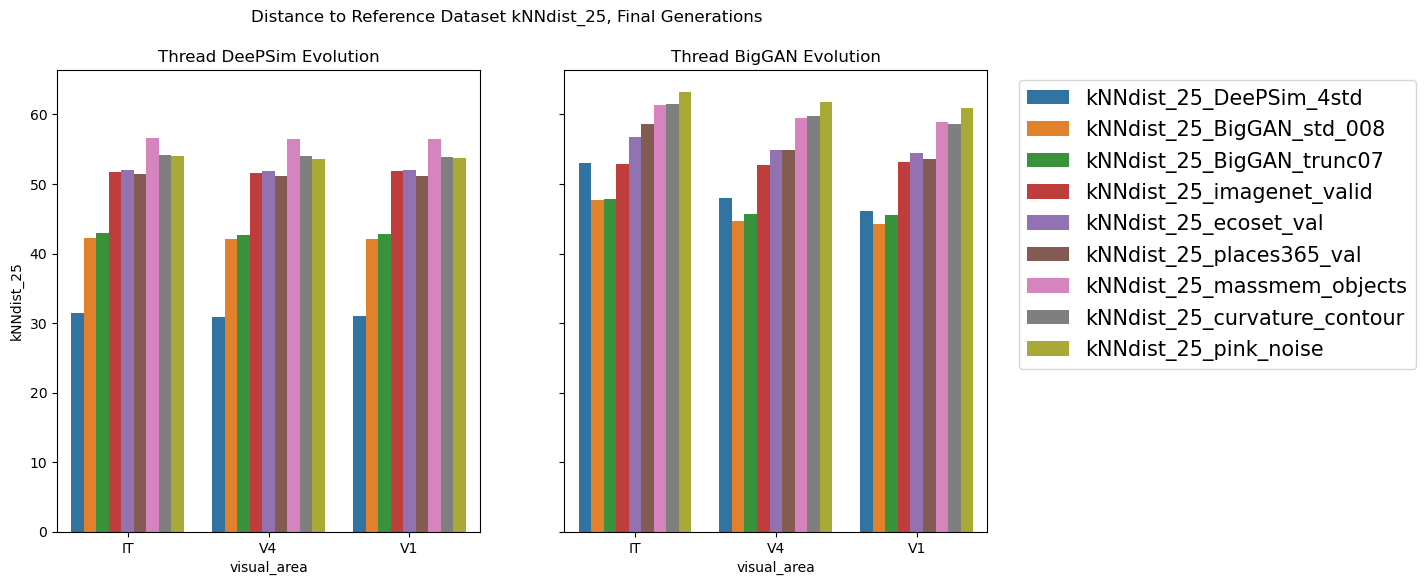

In [27]:
import seaborn as sns
stat_str = "kNNdist_25"
dataset_str_list = ["DeePSim_4std",
                    "BigGAN_std_008",
                    "BigGAN_trunc07",
                    "imagenet_valid",
                    'ecoset_val',
                    'places365_val',
                    'massmem_objects',
                    'curvature_contour',
                    "pink_noise",]
grouped_stats = stats_df_all[final_gen_mask].groupby(["visual_area", "thread"], sort=False)[[
    f"{stat_str}_{dataset_str}"
    for dataset_str in dataset_str_list
]].mean()

# Reshape the dataframe to have a single y column
grouped_stats = grouped_stats.reset_index().melt(id_vars=["visual_area", "thread"], 
                                                 var_name="dataset", value_name=stat_str)

figh, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for thread in [0, 1]:
    # Create the bar plot
    sns.barplot(data=grouped_stats[grouped_stats.thread==thread], 
                x="visual_area", y=stat_str, hue="dataset", ax=axs[thread], 
                legend=True if thread==1 else False)

# Move the legend to the right, outside of the axes
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
axs[0].set_title("Thread DeePSim Evolution")
axs[1].set_title("Thread BigGAN Evolution")
plt.suptitle(f"Distance to Reference Dataset {stat_str}, Final Generations")
plt.show()

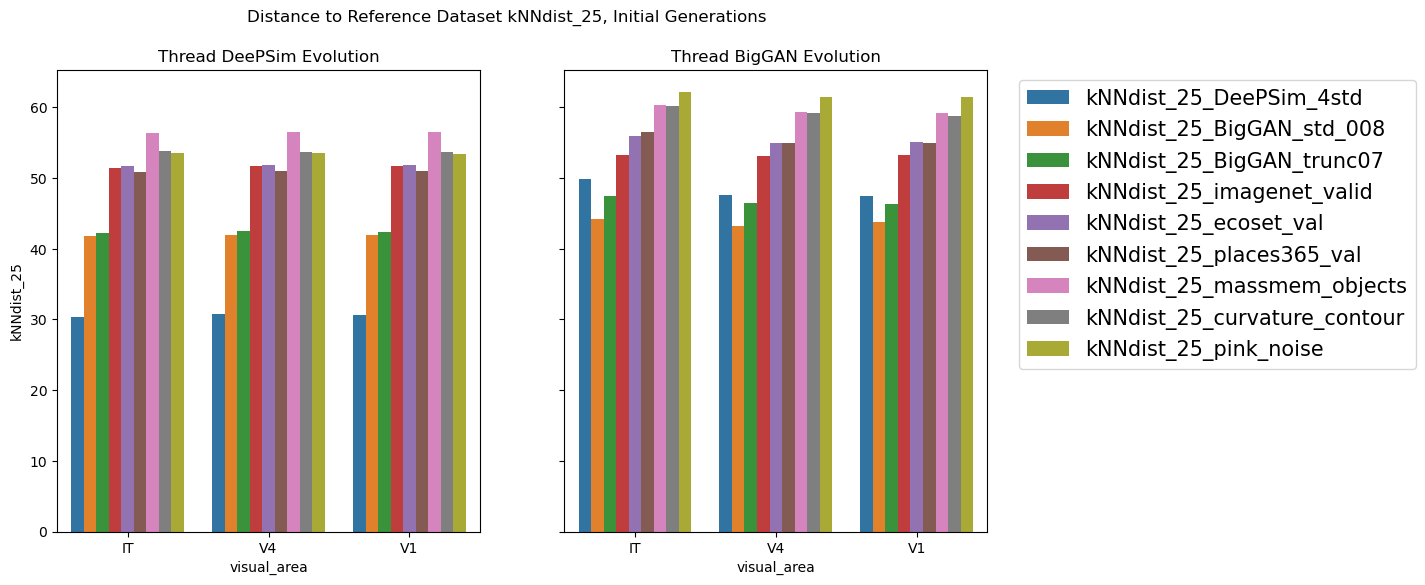

In [28]:
stat_str = "kNNdist_25"
dataset_str_list = ["DeePSim_4std",
                    "BigGAN_std_008",
                    "BigGAN_trunc07",
                    "imagenet_valid",
                    'ecoset_val',
                    'places365_val',
                    'massmem_objects',
                    'curvature_contour',
                    "pink_noise",]
grouped_stats = stats_df_all[init_gen_mask].groupby(["visual_area", "thread"], sort=False)[[
    f"{stat_str}_{dataset_str}"
    for dataset_str in dataset_str_list
]].mean()

# Reshape the dataframe to have a single y column
grouped_stats = grouped_stats.reset_index().melt(id_vars=["visual_area", "thread"], 
                                                 var_name="dataset", value_name=stat_str)

figh, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for thread in [0, 1]:
    # Create the bar plot
    sns.barplot(data=grouped_stats[grouped_stats.thread==thread], 
                x="visual_area", y=stat_str, hue="dataset", ax=axs[thread], 
                legend=True if thread==1 else False)

# Move the legend to the right, outside of the axes
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
axs[0].set_title("Thread DeePSim Evolution")
axs[1].set_title("Thread BigGAN Evolution")
plt.suptitle(f"Distance to Reference Dataset {stat_str}, Initial Generations")
plt.show()

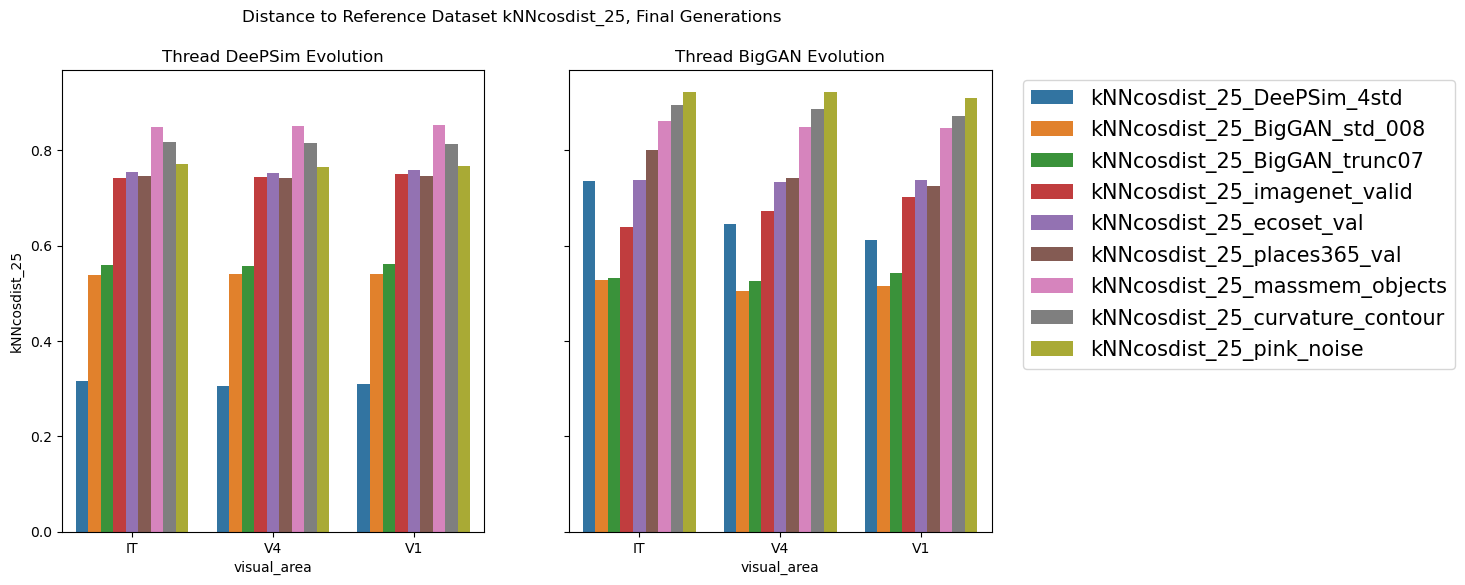

In [29]:
stat_str = "kNNcosdist_25"
dataset_str_list = ["DeePSim_4std",
                    "BigGAN_std_008",
                    "BigGAN_trunc07",
                    "imagenet_valid",
                    'ecoset_val',
                    'places365_val',
                    'massmem_objects',
                    'curvature_contour',
                    "pink_noise",]
grouped_stats = stats_df_all[final_gen_mask].groupby(["visual_area", "thread"], sort=False)[[
    f"{stat_str}_{dataset_str}"
    for dataset_str in dataset_str_list
]].mean()

# Reshape the dataframe to have a single y column
grouped_stats = grouped_stats.reset_index().melt(id_vars=["visual_area", "thread"], 
                                                 var_name="dataset", value_name=stat_str)

figh, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for thread in [0, 1]:
    # Create the bar plot
    sns.barplot(data=grouped_stats[grouped_stats.thread==thread], 
                x="visual_area", y=stat_str, hue="dataset", ax=axs[thread], 
                legend=True if thread==1 else False)

# Move the legend to the right, outside of the axes
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
axs[0].set_title("Thread DeePSim Evolution")
axs[1].set_title("Thread BigGAN Evolution")
plt.suptitle(f"Distance to Reference Dataset {stat_str}, Final Generations")
plt.show()

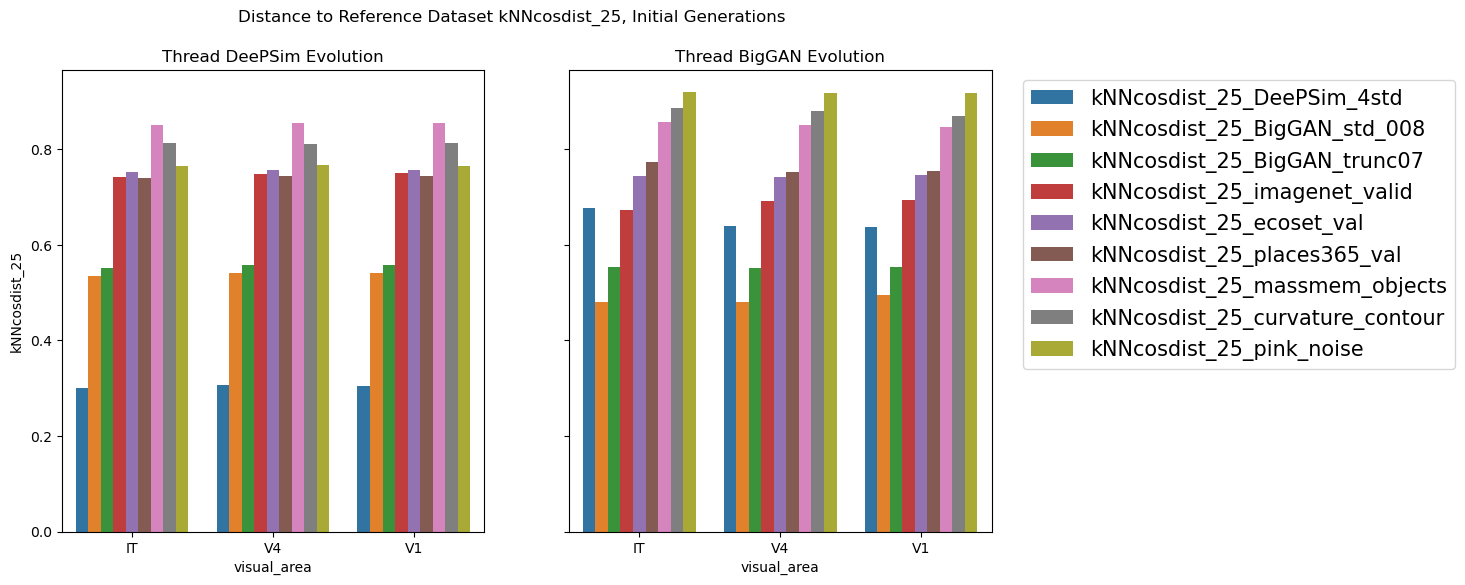

In [30]:
stat_str = "kNNcosdist_25"
dataset_str_list = ["DeePSim_4std",
                    "BigGAN_std_008",
                    "BigGAN_trunc07",
                    "imagenet_valid",
                    'ecoset_val',
                    'places365_val',
                    'massmem_objects',
                    'curvature_contour',
                    "pink_noise",]
grouped_stats = stats_df_all[init_gen_mask].groupby(["visual_area", "thread"], sort=False)[[
    f"{stat_str}_{dataset_str}"
    for dataset_str in dataset_str_list
]].mean()

# Reshape the dataframe to have a single y column
grouped_stats = grouped_stats.reset_index().melt(id_vars=["visual_area", "thread"], 
                                                 var_name="dataset", value_name=stat_str)

figh, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for thread in [0, 1]:
    # Create the bar plot
    sns.barplot(data=grouped_stats[grouped_stats.thread==thread], 
                x="visual_area", y=stat_str, hue="dataset", ax=axs[thread], 
                legend=True if thread==1 else False)

# Move the legend to the right, outside of the axes
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
axs[0].set_title("Thread DeePSim Evolution")
axs[1].set_title("Thread BigGAN Evolution")
plt.suptitle(f"Distance to Reference Dataset {stat_str}, Initial Generations")
plt.show()

### Extrapolate Trajectory for Plotting

* Compute summary statistics (mean, std, sem) for all indices for each block.
* Get rid of final blocks if that block has fewer than 10 samples 
* Extrapolate this summary statstic table by repeating the final gen (max_gen - block) times. 
* Formulate the regular tensor.

#### Scratch zone

In [40]:
stat_names = [k for k in list(stats_df_all) if 
              ("dist" in k) or ("NLL" in k) or ("resp" in k)]
len(stat_names)

154

In [64]:
stats_df_all.groupby(["Expi", "thread", "generation"]).size()

Expi  thread  generation
3     0       1             30
              2             40
              3             40
              4             40
              5             40
                            ..
190   1       15            25
              16            25
              17            25
              18            25
              19            25
Length: 9979, dtype: int64

In [66]:
stats_sum_df

(resp_mean, mean)  (resp_mean, std)  (resp_mean, sem)  \
Expi thread generation                                                          
3    0      1                  117.391220         47.427783          8.659089   
            2                  122.855586         42.129923          6.661326   
            3                  130.201991         37.609073          5.946517   
            4                  131.548824         34.118614          5.394626   
            5                  136.306215         40.075616          6.336511   
...                                   ...               ...               ...   
190  1      15                 303.891236         55.977422         11.195484   
            16                 299.849685         57.474042         11.494808   
            17                 320.253643         62.197230         12.439446   
            18                 310.053156         67.121943         13.424389   
            19                 308.282533         48.173155          9.634631   

                        (MHdist_DeePSim_4std, mean)  \
Expi thread generation                                
3    0      1                            792.845248   
            2                            718.798072   
            3                            787.689179   
            4                            771.514247   
            5                            828.232241   
...                                             ...   
190  1      15                          5125.506152   
            16                          5075.010728   
            17                          4990.068908   
            18                          4611.515504   
            19                          4638.827376   

                        (MHdist_DeePSim_4std, std)  \
Expi thread generation                               
3    0      1                           417.936494   
            2                           272.652791   
            3                           371.401629   
            4                           635.396401   
            5                           336.368930   
...                                            ...   
190  1      15                         1090.389658   
            16                          989.501243   
            17                         1418.104095   
            18                          886.368107   
            19                          881.230225   

                        (MHdist_DeePSim_4std, sem)  (NLL_DeePSim_4std, mean)  \
Expi thread generation                                                         
3    0      1                            76.304415                679.981465   
            2                            43.110192                642.957872   
            3                            58.723754                677.403427   
            4                           100.464992                669.315954   
            5                            53.184598                697.674956   
...                                            ...                       ...   
190  1      15                          218.077932               2846.311920   
            16                          197.900249               2821.064220   
            17                          283.620819               2778.593300   
            18                          177.273621               2589.316572   
            19                          176.246045               2602.972504   

                        (NLL_DeePSim_4std, std)  (NLL_DeePSim_4std, sem)  \
Expi thread generation                                                     
3    0      1                        208.968248                38.152208   
            2                        136.326394                21.555095   
            3                        185.700820                29.361878   
            4                        317.698186                50.232494   
            5                        168.184456       

In [96]:
stats_sum_df = stats_df_all.groupby(["Expi", "thread", "generation"])[stat_names].\
    agg(["mean", "std", "sem"])
cnt_sum_df = stats_df_all.groupby(["Expi", "thread", "generation"]).size()
# create a new columne in stats_sum_df for counts 
stats_sum_df["count"] = cnt_sum_df

/tmp/ipykernel_979744/3350327428.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stats_sum_df["count"] = cnt_sum_df


In [ ]:
filtered_stats_sum_df = stats_sum_df.loc[(3, 0, slice(None)), :]


In [60]:
MAX_GEN = stats_df_all.generation.max()
assert stats_df_all.blockN.max() == MAX_GEN

In [69]:
stats_sum_df.loc[(3, 1, slice(None)), :]

resp_mean                       MHdist_DeePSim_4std  \
                              mean        std        sem                mean   
Expi thread generation                                                         
3    1      1           160.812982  34.272367   6.257250         6028.601610   
            2           171.908302  41.570797   8.314159         6160.126156   
            3           195.262289  31.383659   6.276732         7262.249424   
            4           176.611005  26.232329   5.246466         7611.382624   
            5           199.063291  39.990074   7.998015         7083.016404   
            6           196.523967  34.215014   6.843003         7691.532924   
            7           195.647127  47.398542   9.479708         6957.074256   
            8           214.967996  50.576009  10.115202         7478.649512   
            9           211.984462  46.594553   9.318911         8148.379764   
            10          215.206284  39.612425   7.922485         7676.789012   
            11          221.177929  46.569214   9.313843         7003.258228   
            12          224.640316  43.271110   8.654222         7704.360828   
            13          227.248231  37.230604   7.446121         7970.972672   
            14          218.092002  41.674608   8.334922         8755.405532   
            15          245.058693  43.960931   8.792186         8142.543224   
            16          231.778469  32.682095   6.536419         8232.502400   
            17          224.269617  51.940761  10.388152         7535.518136   
            18          243.201922  50.495131  10.099026         7720.772596   
            19          243.295833  41.310258   8.262052         7688.354024   
            20          228.882067  48.024323   9.604865         7468.090408   
            21          232.901557  37.858080   7.571616         8097.908240   
            22          231.555462  50.828169  10.165634         8211.478864   
            23          245.158166  40.489904   8.097981         8055.544128   
            24          240.013794  45.108740   9.021748         8091.211480   
            25          234.816087  48.713209   9.742642         8504.617428   
            26          236.244467  41.923336   8.384667         8936.953776   
            27          240.500140  34.653754   6.930751         8808.696196   
            28          245.017968  47.600919   9.520184         9026.598944   
            29          244.483460  36.401074   7.280215         8329.560584   
            30          245.826227  39.829248   7.965850         7684.442876   
            31          244.648581  41.289673   8.257935         8274.922536   
            32          231.736613  37.358587   7.471717         8507.318300   
            33          259.086550  47.124397   9.424879         8865.704700   
            34          260.844419  40.797247   8.159449         8576.896772   
            35          251.247826  39.026084   7.805217         8125.365176   
            36          256.846891  47.406583   9.481317         8137.710240   
            37          254.075328  45.035105   9.007021         7993.434640   
            38          232.783117  32.713425   6.542685         8232.971592   
            39          243.618648  32.957759   6.591552         8036.150956   
            40          246.177833  49.578794   9.915759         8286.613164   
            41          239.419312  43.172764   8.634553         7620.245252   
            42          252.662595  45.309570   9.061914         7597.537768   
            43          259.408166  43.399579   8.679916         8125.299124   
            44          238.565761  35.702851   7.140570         8307.157532   
            45          245.074409  35.910797   7.182159         8563.723516   
            46          244.512266  36.721148   7.344230         8585.104648   
            47          253.548474  40.483903   8.096781         7848.803384   
            48          2

### Compute stats and extrapolation!

In [84]:
# find all relevant stats 
stat_names = [k for k in list(stats_df_all) if 
              ("dist" in k) or ("NLL" in k) or ("resp" in k)]
# group by and summarize
stats_sum_df = stats_df_all.groupby(["Expi", "thread", "generation"])[stat_names].\
    agg(["mean", "std", "sem"])
# add count
cnt_sum_df = stats_df_all.groupby(["Expi", "thread", "generation"]).size()
# create a new columne in stats_sum_df for counts 
stats_sum_df["count"] = cnt_sum_df

/tmp/ipykernel_1169226/3589250342.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stats_sum_df["count"] = cnt_sum_df


In [85]:
stats_sum_df.columns

MultiIndex([(               'resp_mean', 'mean'),
            (               'resp_mean',  'std'),
            (               'resp_mean',  'sem'),
            (     'MHdist_DeePSim_4std', 'mean'),
            (     'MHdist_DeePSim_4std',  'std'),
            (     'MHdist_DeePSim_4std',  'sem'),
            (        'NLL_DeePSim_4std', 'mean'),
            (        'NLL_DeePSim_4std',  'std'),
            (        'NLL_DeePSim_4std',  'sem'),
            (  'kNNdist_1_DeePSim_4std', 'mean'),
            ...
            (   'kNNdist_50_pink_noise', 'mean'),
            (   'kNNdist_50_pink_noise',  'std'),
            (   'kNNdist_50_pink_noise',  'sem'),
            ( 'kNNMHdist_50_pink_noise', 'mean'),
            ( 'kNNMHdist_50_pink_noise',  'std'),
            ( 'kNNMHdist_50_pink_noise',  'sem'),
            ('kNNcosdist_50_pink_noise', 'mean'),
            ('kNNcosdist_50_pink_noise',  'std'),
            ('kNNcosdist_50_pink_noise',  'sem'),
            (                   'c

In [82]:
stats_sum_df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]

(9979, 463)

In [111]:
MAX_GEN = stats_df_all.generation.max()
assert stats_df_all.blockN.max() == MAX_GEN
stats_sum_df_extrap = [] 
for Expi in tqdm(meta_df.index):
    for thread in [0, 1]:
        thread_tab = stats_sum_df.loc[(Expi, thread, slice(None))].copy()
        gen_num = thread_tab.shape[0]
        assert gen_num == thread_tab.index.max()
        if thread_tab.loc[gen_num, "count"].item() < 10:
            print(f"Expi {Expi} thread {thread} last gen has less than 10 samples")
            # chop off the last gen
            thread_tab = thread_tab.drop(gen_num)
            gen_num = thread_tab.shape[0]
        
        if gen_num < MAX_GEN:
            # extraploate the last gen towards the max gen
            # Note, here it needs to be a 1 row dataframe, not a series to concat properly
            last_gen_row = thread_tab.loc[gen_num:gen_num+1]
            # thread_tab.loc[gen_num-1:gen_num+1].mean().to_frame().T
            # repeat the last rows
            thread_tab = pd.concat([thread_tab] + [last_gen_row] * (MAX_GEN - gen_num))
            assert thread_tab.shape[0] == MAX_GEN
            # set the index to be the generation number
            thread_tab.index = np.arange(1, MAX_GEN+1)
            # create a new boolean column for extrapolation
            extrap_mask = np.zeros(MAX_GEN, dtype=bool)
            extrap_mask[gen_num:] = True
            thread_tab["is_extrap"] = extrap_mask
        else:
            thread_tab["is_extrap"] = np.zeros(MAX_GEN, dtype=bool)
        
        # create columns for Expi and thread
        thread_tab["Expi"] = Expi
        thread_tab["thread"] = thread
        # set generation number as a column
        thread_tab["generation"] = thread_tab.index
        thread_tab["visual_area"] = meta_df.loc[Expi, "visual_area"]
        thread_tab["Animal"] = meta_df.loc[Expi, "Animal"]
        stats_sum_df_extrap.append(thread_tab)
        # raise RuntimeError("Stop here")

stats_sum_df_extrap = pd.concat(stats_sum_df_extrap, ignore_index=True)
# drop the c

  5%|▍         | 8/170 [00:00<00:02, 77.60it/s]

Expi 3 thread 0 last gen has less than 10 samples
Expi 3 thread 1 last gen has less than 10 samples
Expi 4 thread 0 last gen has less than 10 samples
Expi 4 thread 1 last gen has less than 10 samples
Expi 5 thread 0 last gen has less than 10 samples
Expi 5 thread 1 last gen has less than 10 samples
Expi 6 thread 0 last gen has less than 10 samples
Expi 6 thread 1 last gen has less than 10 samples
Expi 8 thread 0 last gen has less than 10 samples
Expi 8 thread 1 last gen has less than 10 samples
Expi 12 thread 0 last gen has less than 10 samples
Expi 13 thread 0 last gen has less than 10 samples
Expi 13 thread 1 last gen has less than 10 samples
Expi 14 thread 0 last gen has less than 10 samples
Expi 14 thread 1 last gen has less than 10 samples
Expi 15 thread 0 last gen has less than 10 samples
Expi 15 thread 1 last gen has less than 10 samples
Expi 16 thread 0 last gen has less than 10 samples
Expi 16 thread 1 last gen has less than 10 samples
Expi 18 thread 0 last gen has less than 1

 15%|█▍        | 25/170 [00:00<00:01, 79.49it/s]

Expi 20 thread 1 last gen has less than 10 samples
Expi 21 thread 0 last gen has less than 10 samples
Expi 21 thread 1 last gen has less than 10 samples
Expi 22 thread 1 last gen has less than 10 samples
Expi 23 thread 1 last gen has less than 10 samples
Expi 25 thread 0 last gen has less than 10 samples
Expi 25 thread 1 last gen has less than 10 samples
Expi 26 thread 1 last gen has less than 10 samples
Expi 32 thread 0 last gen has less than 10 samples
Expi 32 thread 1 last gen has less than 10 samples
Expi 35 thread 0 last gen has less than 10 samples
Expi 35 thread 1 last gen has less than 10 samples


 25%|██▌       | 43/170 [00:00<00:01, 79.21it/s]

Expi 37 thread 1 last gen has less than 10 samples
Expi 38 thread 1 last gen has less than 10 samples
Expi 39 thread 0 last gen has less than 10 samples
Expi 39 thread 1 last gen has less than 10 samples
Expi 40 thread 0 last gen has less than 10 samples
Expi 40 thread 1 last gen has less than 10 samples
Expi 41 thread 1 last gen has less than 10 samples
Expi 42 thread 0 last gen has less than 10 samples
Expi 42 thread 1 last gen has less than 10 samples
Expi 43 thread 0 last gen has less than 10 samples
Expi 43 thread 1 last gen has less than 10 samples
Expi 45 thread 0 last gen has less than 10 samples
Expi 45 thread 1 last gen has less than 10 samples
Expi 46 thread 0 last gen has less than 10 samples
Expi 46 thread 1 last gen has less than 10 samples
Expi 49 thread 0 last gen has less than 10 samples
Expi 49 thread 1 last gen has less than 10 samples
Expi 50 thread 0 last gen has less than 10 samples
Expi 50 thread 1 last gen has less than 10 samples


 35%|███▌      | 60/170 [00:00<00:01, 80.35it/s]

Expi 53 thread 1 last gen has less than 10 samples
Expi 55 thread 0 last gen has less than 10 samples
Expi 55 thread 1 last gen has less than 10 samples
Expi 57 thread 0 last gen has less than 10 samples
Expi 57 thread 1 last gen has less than 10 samples
Expi 63 thread 0 last gen has less than 10 samples
Expi 63 thread 1 last gen has less than 10 samples
Expi 64 thread 0 last gen has less than 10 samples
Expi 64 thread 1 last gen has less than 10 samples
Expi 65 thread 0 last gen has less than 10 samples
Expi 65 thread 1 last gen has less than 10 samples
Expi 66 thread 0 last gen has less than 10 samples
Expi 66 thread 1 last gen has less than 10 samples
Expi 68 thread 0 last gen has less than 10 samples
Expi 68 thread 1 last gen has less than 10 samples
Expi 69 thread 0 last gen has less than 10 samples
Expi 69 thread 1 last gen has less than 10 samples
Expi 70 thread 0 last gen has less than 10 samples
Expi 70 thread 1 last gen has less than 10 samples
Expi 72 thread 1 last gen has l

 46%|████▋     | 79/170 [00:00<00:01, 84.04it/s]

Expi 78 thread 0 last gen has less than 10 samples
Expi 78 thread 1 last gen has less than 10 samples
Expi 89 thread 0 last gen has less than 10 samples
Expi 89 thread 1 last gen has less than 10 samples
Expi 90 thread 1 last gen has less than 10 samples
Expi 92 thread 0 last gen has less than 10 samples
Expi 92 thread 1 last gen has less than 10 samples
Expi 96 thread 0 last gen has less than 10 samples
Expi 96 thread 1 last gen has less than 10 samples
Expi 98 thread 0 last gen has less than 10 samples
Expi 99 thread 1 last gen has less than 10 samples
Expi 101 thread 1 last gen has less than 10 samples


 57%|█████▋    | 97/170 [00:01<00:00, 82.14it/s]

Expi 103 thread 0 last gen has less than 10 samples
Expi 103 thread 1 last gen has less than 10 samples
Expi 104 thread 1 last gen has less than 10 samples
Expi 105 thread 1 last gen has less than 10 samples
Expi 106 thread 0 last gen has less than 10 samples
Expi 106 thread 1 last gen has less than 10 samples
Expi 107 thread 1 last gen has less than 10 samples
Expi 109 thread 0 last gen has less than 10 samples
Expi 110 thread 0 last gen has less than 10 samples
Expi 110 thread 1 last gen has less than 10 samples
Expi 111 thread 1 last gen has less than 10 samples
Expi 112 thread 0 last gen has less than 10 samples
Expi 112 thread 1 last gen has less than 10 samples
Expi 114 thread 0 last gen has less than 10 samples
Expi 114 thread 1 last gen has less than 10 samples
Expi 116 thread 0 last gen has less than 10 samples
Expi 116 thread 1 last gen has less than 10 samples
Expi 117 thread 0 last gen has less than 10 samples
Expi 117 thread 1 last gen has less than 10 samples
Expi 118 thr

 68%|██████▊   | 115/170 [00:01<00:00, 81.04it/s]

Expi 120 thread 1 last gen has less than 10 samples
Expi 122 thread 1 last gen has less than 10 samples
Expi 123 thread 1 last gen has less than 10 samples
Expi 124 thread 1 last gen has less than 10 samples
Expi 126 thread 1 last gen has less than 10 samples
Expi 129 thread 0 last gen has less than 10 samples
Expi 129 thread 1 last gen has less than 10 samples
Expi 132 thread 0 last gen has less than 10 samples
Expi 132 thread 1 last gen has less than 10 samples
Expi 135 thread 1 last gen has less than 10 samples
Expi 136 thread 0 last gen has less than 10 samples
Expi 136 thread 1 last gen has less than 10 samples


 78%|███████▊  | 133/170 [00:01<00:00, 80.90it/s]

Expi 137 thread 0 last gen has less than 10 samples
Expi 137 thread 1 last gen has less than 10 samples
Expi 139 thread 1 last gen has less than 10 samples
Expi 142 thread 1 last gen has less than 10 samples
Expi 143 thread 0 last gen has less than 10 samples
Expi 143 thread 1 last gen has less than 10 samples
Expi 145 thread 0 last gen has less than 10 samples
Expi 145 thread 1 last gen has less than 10 samples
Expi 146 thread 0 last gen has less than 10 samples
Expi 146 thread 1 last gen has less than 10 samples
Expi 147 thread 0 last gen has less than 10 samples
Expi 147 thread 1 last gen has less than 10 samples
Expi 148 thread 0 last gen has less than 10 samples
Expi 148 thread 1 last gen has less than 10 samples
Expi 149 thread 0 last gen has less than 10 samples
Expi 149 thread 1 last gen has less than 10 samples
Expi 151 thread 1 last gen has less than 10 samples
Expi 152 thread 0 last gen has less than 10 samples


 89%|████████▉ | 151/170 [00:01<00:00, 81.49it/s]

Expi 162 thread 0 last gen has less than 10 samples
Expi 162 thread 1 last gen has less than 10 samples
Expi 164 thread 0 last gen has less than 10 samples
Expi 165 thread 0 last gen has less than 10 samples
Expi 165 thread 1 last gen has less than 10 samples
Expi 168 thread 0 last gen has less than 10 samples
Expi 168 thread 1 last gen has less than 10 samples
Expi 169 thread 0 last gen has less than 10 samples
Expi 169 thread 1 last gen has less than 10 samples
Expi 170 thread 0 last gen has less than 10 samples
Expi 170 thread 1 last gen has less than 10 samples
Expi 173 thread 0 last gen has less than 10 samples
Expi 173 thread 1 last gen has less than 10 samples
Expi 174 thread 0 last gen has less than 10 samples
Expi 174 thread 1 last gen has less than 10 samples
Expi 175 thread 0 last gen has less than 10 samples
Expi 175 thread 1 last gen has less than 10 samples
Expi 176 thread 0 last gen has less than 10 samples
Expi 176 thread 1 last gen has less than 10 samples


100%|██████████| 170/170 [00:02<00:00, 81.59it/s]


Expi 184 thread 0 last gen has less than 10 samples
Expi 184 thread 1 last gen has less than 10 samples
Expi 187 thread 0 last gen has less than 10 samples
Expi 187 thread 1 last gen has less than 10 samples
Expi 188 thread 0 last gen has less than 10 samples
Expi 188 thread 1 last gen has less than 10 samples
Expi 189 thread 0 last gen has less than 10 samples
Expi 189 thread 1 last gen has less than 10 samples


In [112]:
stats_sum_df_extrap.to_csv(join(tabdir, "Evol_img_DINO_embed_MHdist_stats_extrap.csv"))

In [107]:
19040 // 170 // 2 // 56

1

In [99]:
stats_sum_df_extrap

resp_mean                      MHdist_DeePSim_4std              \
          mean        std       sem                mean         std   
1   117.391220  47.427783  8.659089          792.845248  417.936494   
2   122.855586  42.129923  6.661326          718.798072  272.652791   
3   130.201991  37.609073  5.946517          787.689179  371.401629   
4   131.548824  34.118614  5.394626          771.514247  635.396401   
5   136.306215  40.075616  6.336511          828.232241  336.368930   
..         ...        ...       ...                 ...         ...   
52  308.282533  48.173155  9.634631         4638.827376  881.230225   
53  308.282533  48.173155  9.634631         4638.827376  881.230225   
54  308.282533  48.173155  9.634631         4638.827376  881.230225   
55  308.282533  48.173155  9.634631         4638.827376  881.230225   
56  308.282533  48.173155  9.634631         4638.827376  881.230225   

               NLL_DeePSim_4std                        kNNdist_1_DeePSim_4std  \
           sem             mean         std        sem                   mean   
1    76.304415       679.981465  208.968248  38.152208              26.602501   
2    43.110192       642.957872  136.326394  21.555095              25.880486   
3    58.723754       677.403427  185.700820  29.361878              26.419939   
4   100.464992       669.315954  317.698186  50.232494              25.809836   
5    53.184598       697.674956  168.184456  26.592297              27.086107   
..         ...              ...         ...        ...                    ...   
52  176.246045      2602.972504  440.615109  88.123022              42.113975   
53  176.246045      2602.972504  440.615109  88.123022              42.113975   
54  176.246045      2602.972504  440.615109  88.123022              42.113975   
55  176.246045      2602.972504  440.615109  88.123022              42.113975   
56  176.246045      2602.972504  440.615109  88.123022              42.113975   

    ... kNNdist_50_pink_noise kNNMHdist_50_pink_noise                        \
    ...                   sem                    mean        std        sem   
1   ...              0.345183              769.806293  54.406497   9.933222   
2   ...              0.285748              762.354955  59.217642   9.363131   
3   ...              0.282580              763.516084  59.985937   9.484609   
4   ...              0.333615              766.433378  63.281646  10.005707   
5   ...              0.286308              788.785267  60.897956   9.628812   
..  ...                   ...                     ...        ...        ...   
52  ...              0.259409              934.187984  51.775337  10.355067   
53  ...              0.259409              934.187984  51.775337  10.355067   
54  ...              0.259409              934.187984  51.775337  10.355067   
55  ...              0.259409              934.187984  51.775337  10.355067   
56  ...              0.259409              934.187984  51.775337  10.355067   

   kNNcosdist_50_pink_noise                     count Expi thread  
                       mean       std       sem                    
1                  0.765045  0.040861  0.007460    30    3      0  
2                  0.751348  0.040723  0.006439    40    3      0  
3                  0.750429  0.031372  0.004960    40    3      0  
4                  0.756162  0.041880  0.006622    40    3      0  
5                  0.765057  0.036950  0.005842    40    3      0  
..                      ...       ...       ...   ...  ...    ...  
52                 0.913033  0.020600  0.004120    25  190      1  
53                 0.913033  0.020600  0.004120    25  190      1  
54                 0.913033  0.020600  0.004120    25  190      1  
55                 0.913033  0.020600  0.004120    25  190      1  
56                 0.913033  0.020600  0.004120    25  190      1  

[19040 rows x 465 columns]

### Visualize Extrapolated Evol Traj Analysis

In [91]:
stats_sum_df_extrap = pd.read_csv(join(tabdir, "Evol_img_DINO_embed_MHdist_stats_extrap.csv"), index_col=0, header=[0, 1])
# fix the loading error of the singular column name
colname_tups = []
for var, stat in stats_sum_df_extrap.columns:
    if "Unnamed" in stat:
        colname_tups.append((var, "")) # (, "")
    else:
        colname_tups.append((var, stat))

stats_sum_df_extrap.columns = pd.MultiIndex.from_tuples(colname_tups)

/tmp/ipykernel_1169226/979529479.py:1: DtypeWarning: Columns (464) have mixed types. Specify dtype option on import or set low_memory=False.
  stats_sum_df_extrap = pd.read_csv(join(tabdir, "Evol_img_DINO_embed_MHdist_stats_extrap.csv"), index_col=0, header=[0, 1])


In [119]:
list(MH_eig_col)


['DeePSim_4std',
 'BigGAN_trunc07',
 'BigGAN_std_008',
 'imagenet_valid',
 'ecoset_val',
 'places365_val',
 'massmem_objects',
 'curvature_contour',
 'pink_noise']

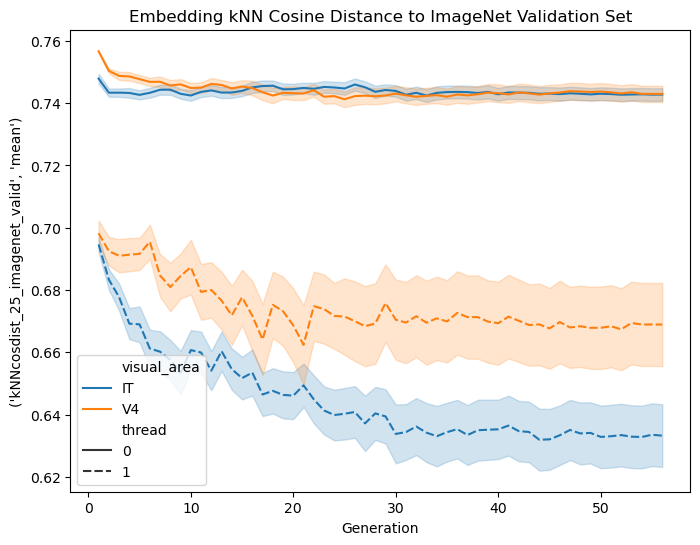

In [107]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
             x="generation", y=("kNNcosdist_25_imagenet_valid","mean"), 
             style="thread",errorbar="se", hue="visual_area",  # ci=68, 
             hue_order=["IT", "V4"],
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.title("Embedding kNN Cosine Distance to ImageNet Validation Set")
plt.show()

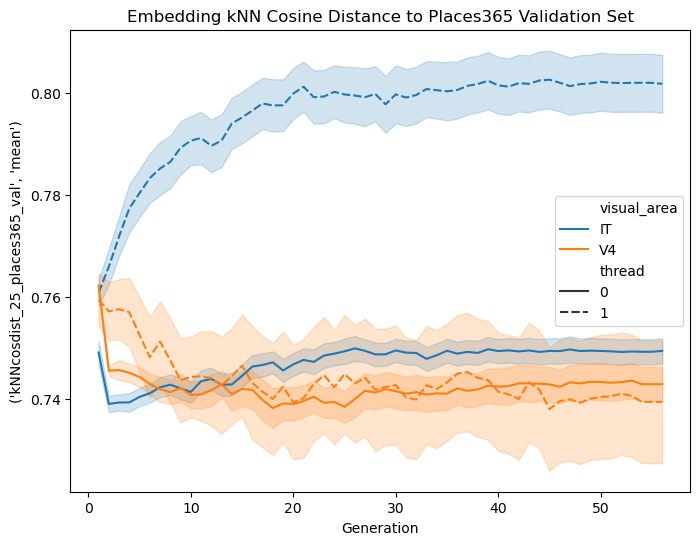

In [95]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
             x="generation", y=("kNNcosdist_25_places365_val","mean"), 
             style="thread",errorbar="se", hue="visual_area",  # ci=68, 
             hue_order=["IT", "V4"],
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.title("Embedding kNN Cosine Distance to Places365 Validation Set")
plt.show()

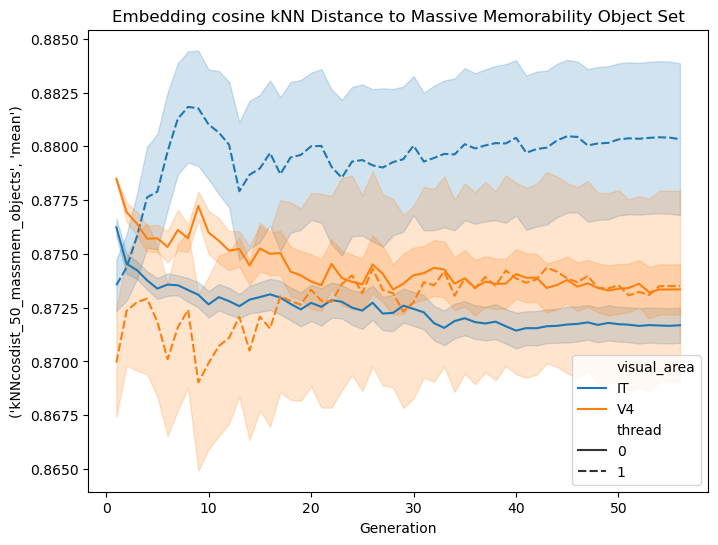

In [104]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
             x="generation", y=("kNNcosdist_50_massmem_objects","mean"), 
             style="thread",errorbar="se", hue="visual_area",  # ci=68, 
             hue_order=["IT", "V4"],
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.title("Embedding cosine kNN Distance to Massive Memorability Object Set")
plt.show()

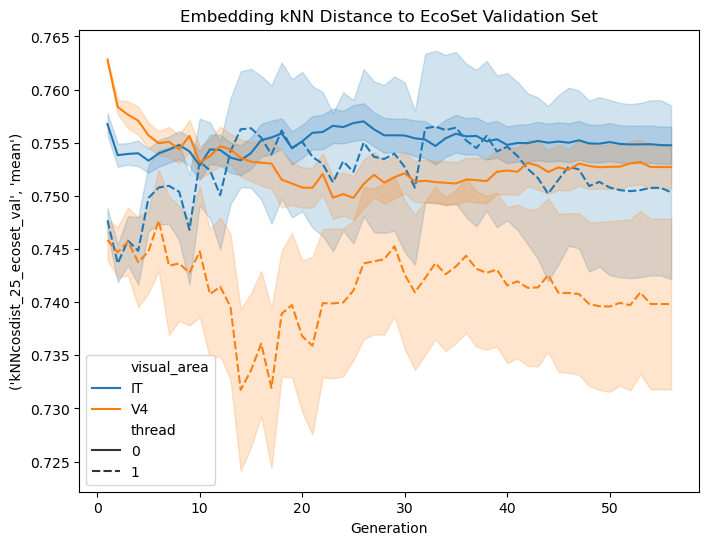

In [128]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
             x="generation", y=("kNNcosdist_25_ecoset_val","mean"), 
             style="thread",errorbar="se", hue="visual_area",  # ci=68, 
             hue_order=["IT", "V4"],
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.title("Embedding kNN Distance to EcoSet Validation Set")
plt.show()

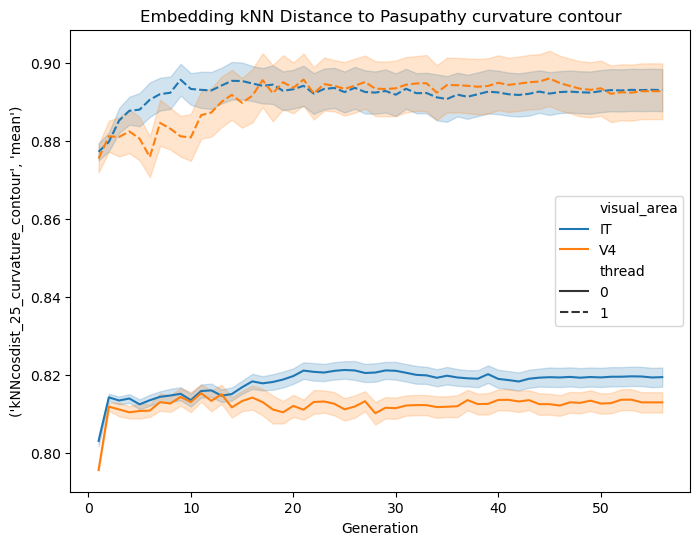

In [127]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
             x="generation", y=("kNNcosdist_25_curvature_contour","mean"), 
             style="thread",errorbar="se", hue="visual_area",  # ci=68, 
             hue_order=["IT", "V4"],
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.title("Embedding kNN Distance to Pasupathy curvature contour")
plt.show()

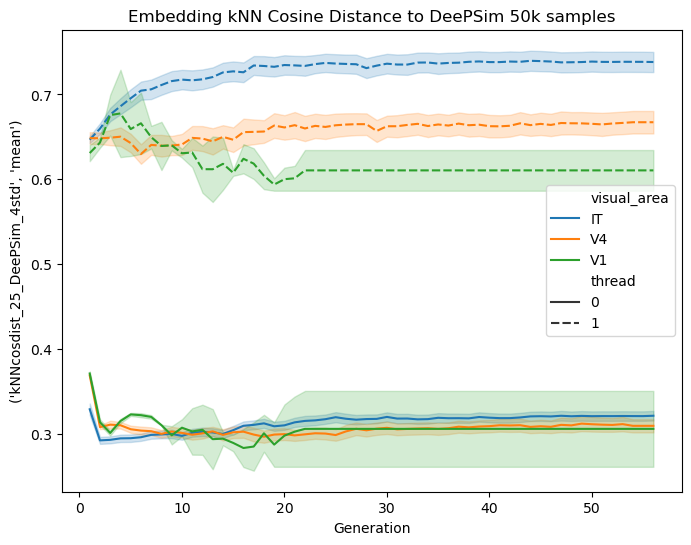

In [115]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
             x="generation", y=("kNNcosdist_25_DeePSim_4std","mean"), 
             style="thread",errorbar="se", hue="visual_area",  # ci=68, 
             hue_order=["IT", "V4", "V1"],
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.title("Embedding kNN Cosine Distance to DeePSim 50k samples")
plt.show()

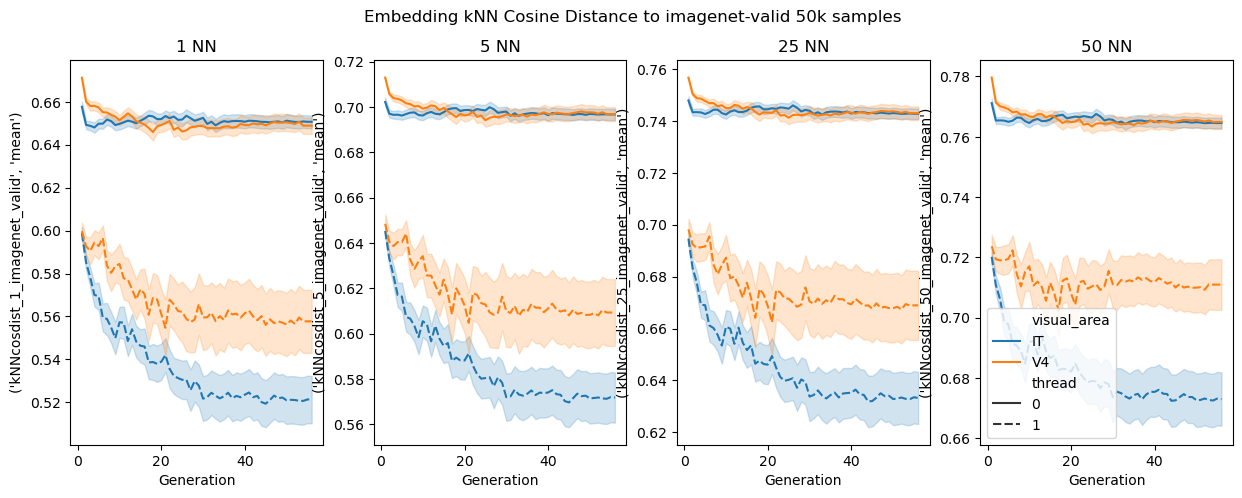

In [131]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
figh, axs = plt.subplots(1, 4, figsize=[15, 5])
for ki, k in enumerate([1, 5, 25, 50]):
    sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
                x="generation", y=(f"kNNcosdist_{k}_imagenet_valid","mean"), 
                style="thread",errorbar="se", hue="visual_area",  # ci=68, 
                hue_order=["IT", "V4"],
                n_boot=0, err_style="band", palette="tab10", ax=axs[ki],
                legend=True if ki==3 else False)
    axs[ki].set_xlabel("Generation")
    axs[ki].set_title(f"{k} NN")
plt.suptitle("Embedding kNN Cosine Distance to imagenet-valid 50k samples")
plt.show()

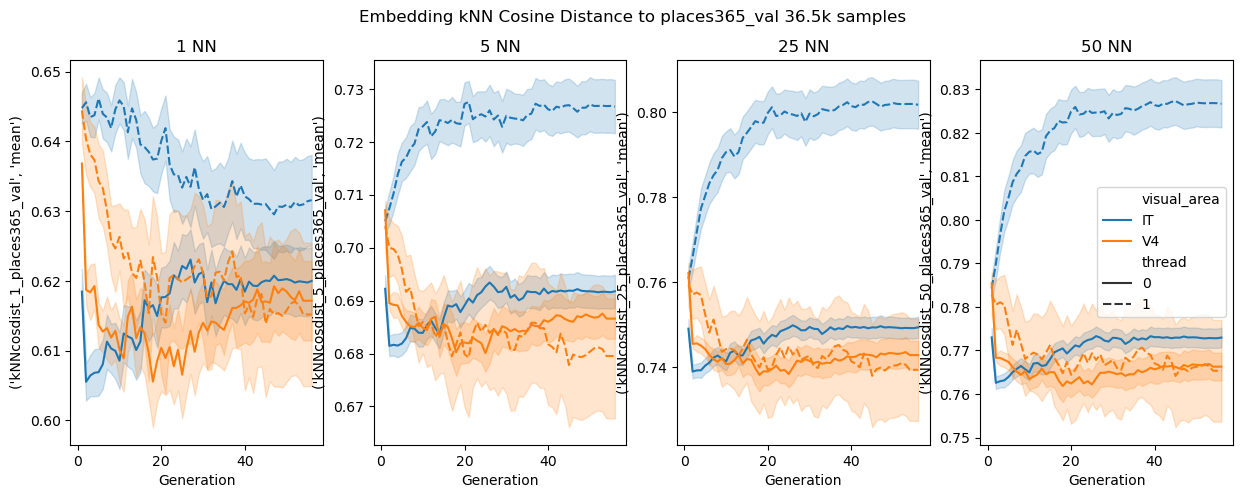

In [132]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
figh, axs = plt.subplots(1, 4, figsize=[15, 5])
for ki, k in enumerate([1, 5, 25, 50]):
    sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
                x="generation", y=(f"kNNcosdist_{k}_places365_val","mean"), 
                style="thread",errorbar="se", hue="visual_area",  # ci=68, 
                hue_order=["IT", "V4"],
                n_boot=0, err_style="band", palette="tab10", ax=axs[ki],
                legend=True if ki==3 else False)
    axs[ki].set_xlabel("Generation")
    axs[ki].set_title(f"{k} NN")
plt.suptitle("Embedding kNN Cosine Distance to places365_val 36.5k samples")
plt.show()

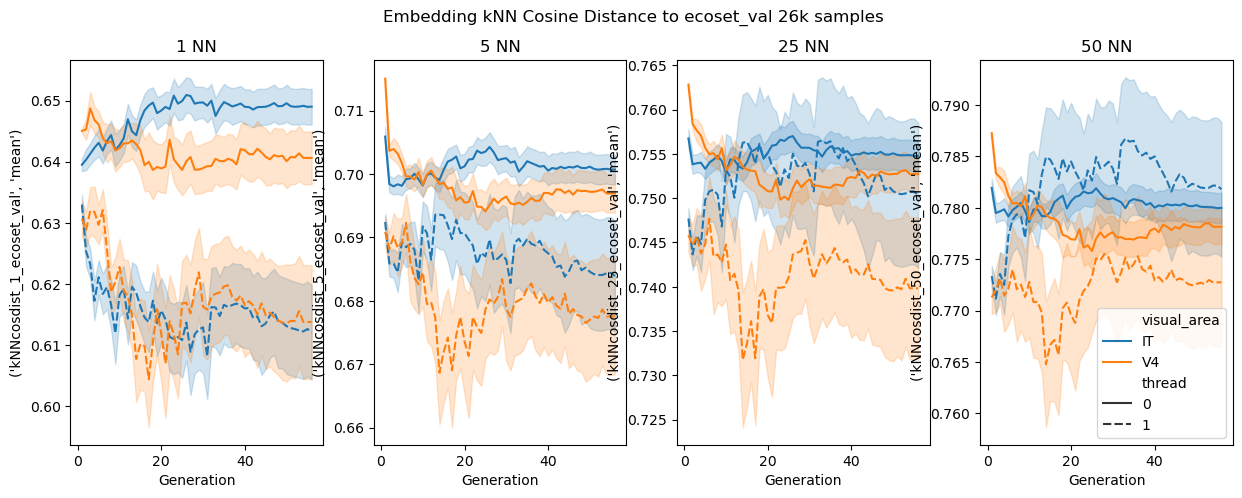

In [134]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
figh, axs = plt.subplots(1, 4, figsize=[15, 5])
for ki, k in enumerate([1, 5, 25, 50]):
    sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
                x="generation", y=(f"kNNcosdist_{k}_ecoset_val","mean"), 
                style="thread",errorbar="se", hue="visual_area",  # ci=68, 
                hue_order=["IT", "V4"],
                n_boot=0, err_style="band", palette="tab10", ax=axs[ki],
                legend=True if ki==3 else False)
    axs[ki].set_xlabel("Generation")
    axs[ki].set_title(f"{k} NN")
plt.suptitle("Embedding kNN Cosine Distance to ecoset_val 26k samples")
plt.show()

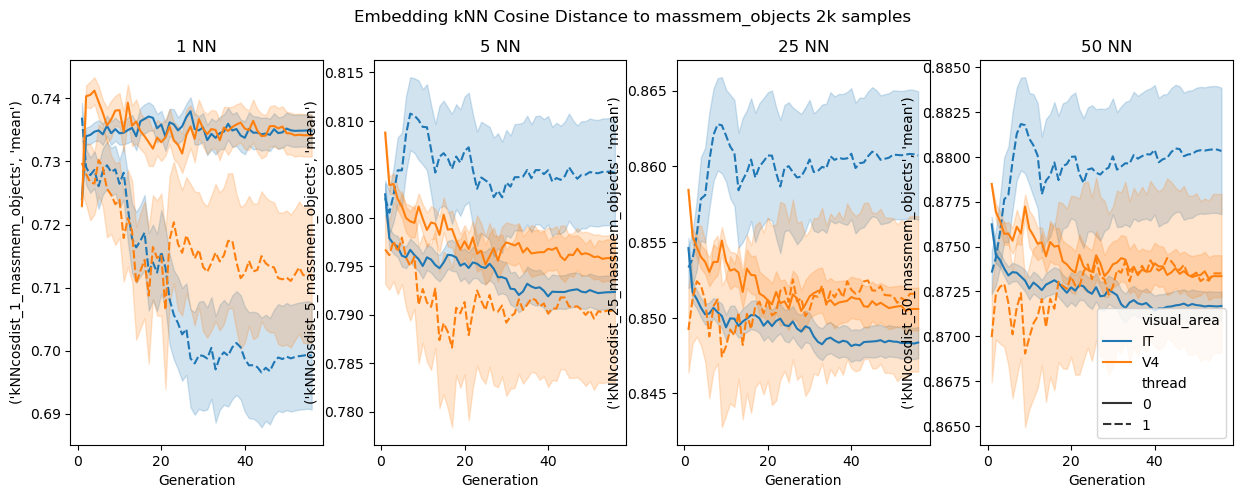

In [133]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
figh, axs = plt.subplots(1, 4, figsize=[15, 5])
for ki, k in enumerate([1, 5, 25, 50]):
    sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
                x="generation", y=(f"kNNcosdist_{k}_massmem_objects","mean"), 
                style="thread",errorbar="se", hue="visual_area",  # ci=68, 
                hue_order=["IT", "V4"],
                n_boot=0, err_style="band", palette="tab10", ax=axs[ki],
                legend=True if ki==3 else False)
    axs[ki].set_xlabel("Generation")
    axs[ki].set_title(f"{k} NN")
plt.suptitle("Embedding kNN Cosine Distance to massmem_objects 2k samples")
plt.show()

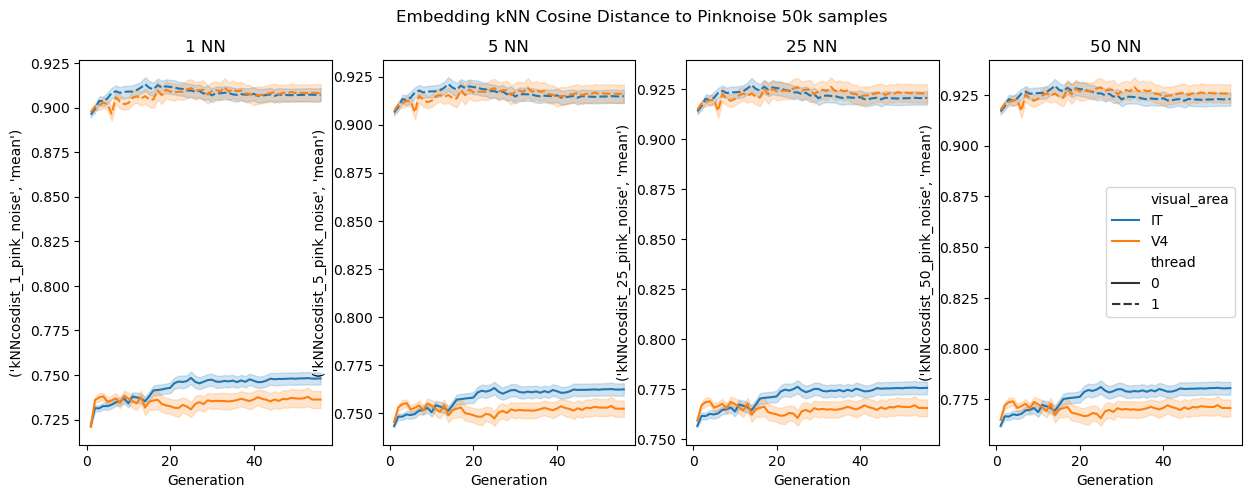

In [137]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
figh, axs = plt.subplots(1, 4, figsize=[15, 5])
for ki, k in enumerate([1, 5, 25, 50]):
    sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
                x="generation", y=(f"kNNcosdist_{k}_pink_noise","mean"), 
                style="thread",errorbar="se", hue="visual_area",  # ci=68, 
                hue_order=["IT", "V4"],
                n_boot=0, err_style="band", palette="tab10", ax=axs[ki],
                legend=True if ki==3 else False)
    axs[ki].set_xlabel("Generation")
    axs[ki].set_title(f"{k} NN")
plt.suptitle("Embedding kNN Cosine Distance to Pinknoise 50k samples")
plt.show()

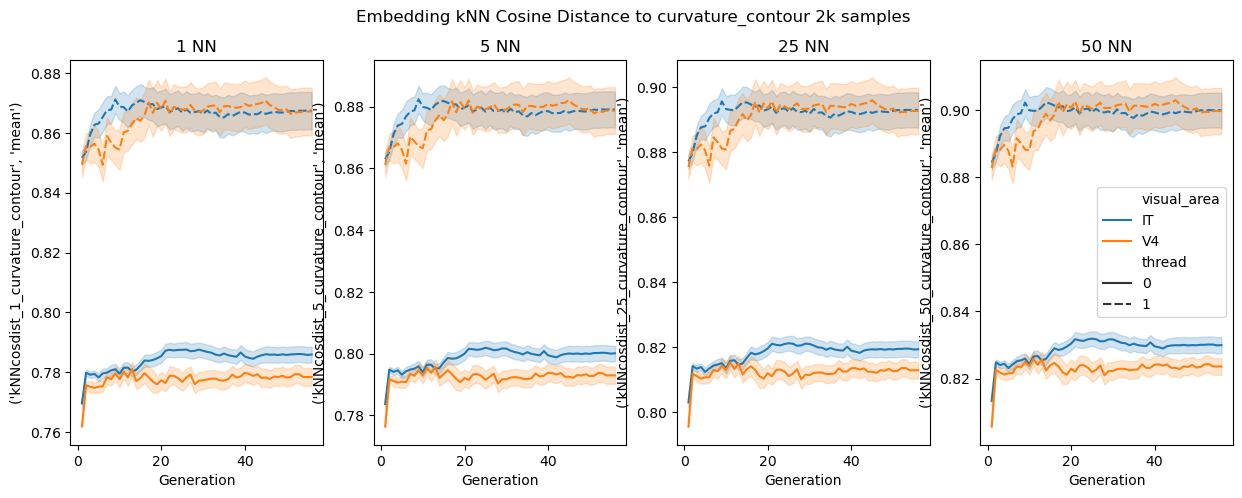

In [138]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
figh, axs = plt.subplots(1, 4, figsize=[15, 5])
for ki, k in enumerate([1, 5, 25, 50]):
    sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
                x="generation", y=(f"kNNcosdist_{k}_curvature_contour","mean"), 
                style="thread",errorbar="se", hue="visual_area",  # ci=68, 
                hue_order=["IT", "V4"],
                n_boot=0, err_style="band", palette="tab10", ax=axs[ki],
                legend=True if ki==3 else False)
    axs[ki].set_xlabel("Generation")
    axs[ki].set_title(f"{k} NN")
plt.suptitle("Embedding kNN Cosine Distance to curvature_contour 2k samples")
plt.show()

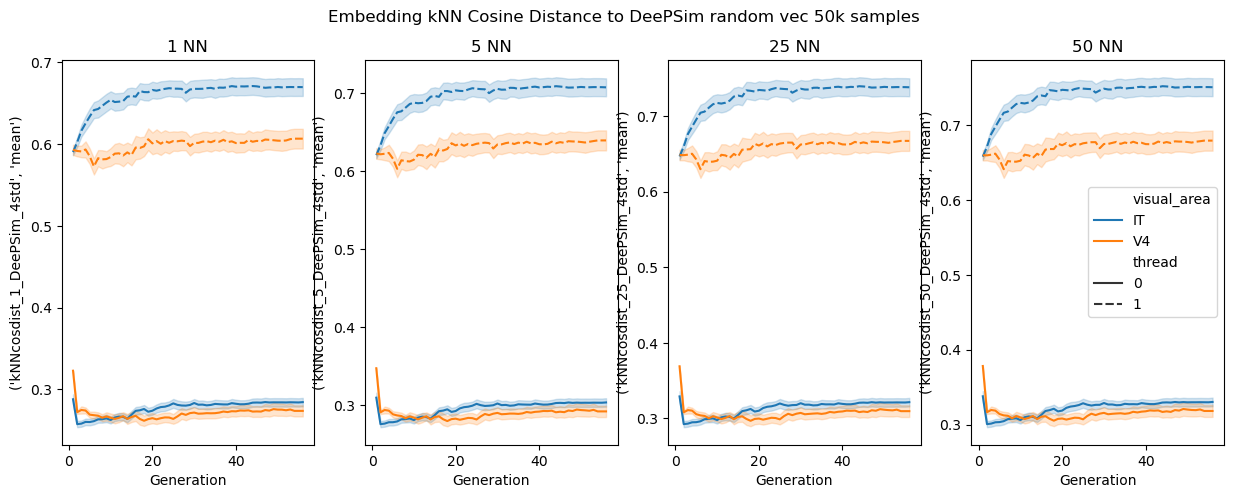

In [130]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
figh, axs = plt.subplots(1, 4, figsize=[15, 5])
for ki, k in enumerate([1, 5, 25, 50]):
    sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
                x="generation", y=(f"kNNcosdist_{k}_DeePSim_4std","mean"), 
                style="thread",errorbar="se", hue="visual_area",  # ci=68, 
                hue_order=["IT", "V4"],
                n_boot=0, err_style="band", palette="tab10", ax=axs[ki],
                legend=True if ki==3 else False)
    axs[ki].set_xlabel("Generation")
    axs[ki].set_title(f"{k} NN")
plt.suptitle("Embedding kNN Cosine Distance to DeePSim random vec 50k samples")
plt.show()

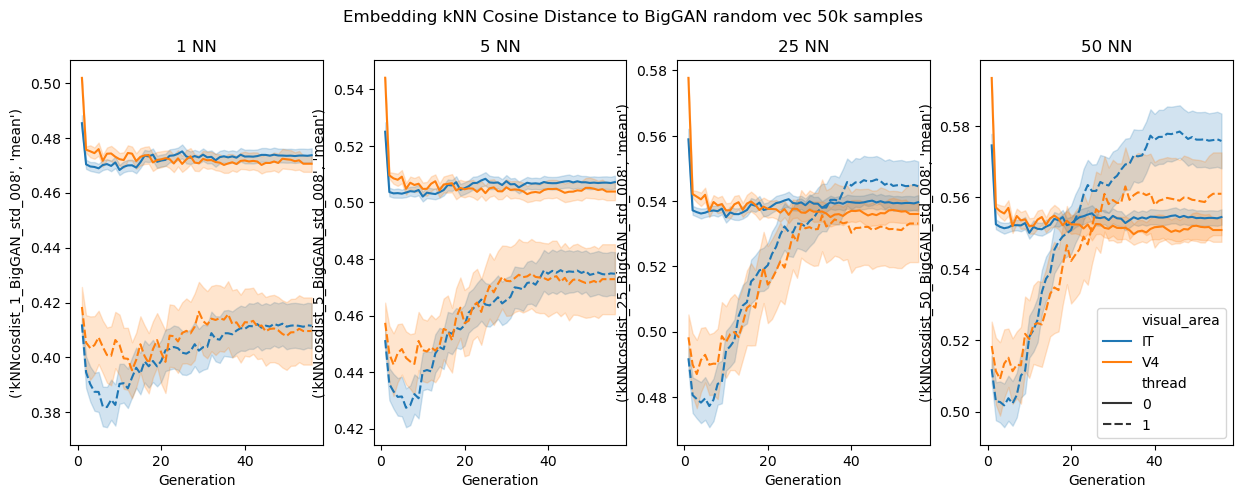

In [129]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
figh, axs = plt.subplots(1, 4, figsize=[15, 5])
for ki, k in enumerate([1, 5, 25, 50]):
    sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
                x="generation", y=(f"kNNcosdist_{k}_BigGAN_std_008","mean"), 
                style="thread",errorbar="se", hue="visual_area",  # ci=68, 
                hue_order=["IT", "V4"],
                n_boot=0, err_style="band", palette="tab10", ax=axs[ki],
                legend=True if ki==3 else False)
    axs[ki].set_xlabel("Generation")
    axs[ki].set_title(f"{k} NN")
plt.suptitle("Embedding kNN Cosine Distance to BigGAN random vec 50k samples")
plt.show()

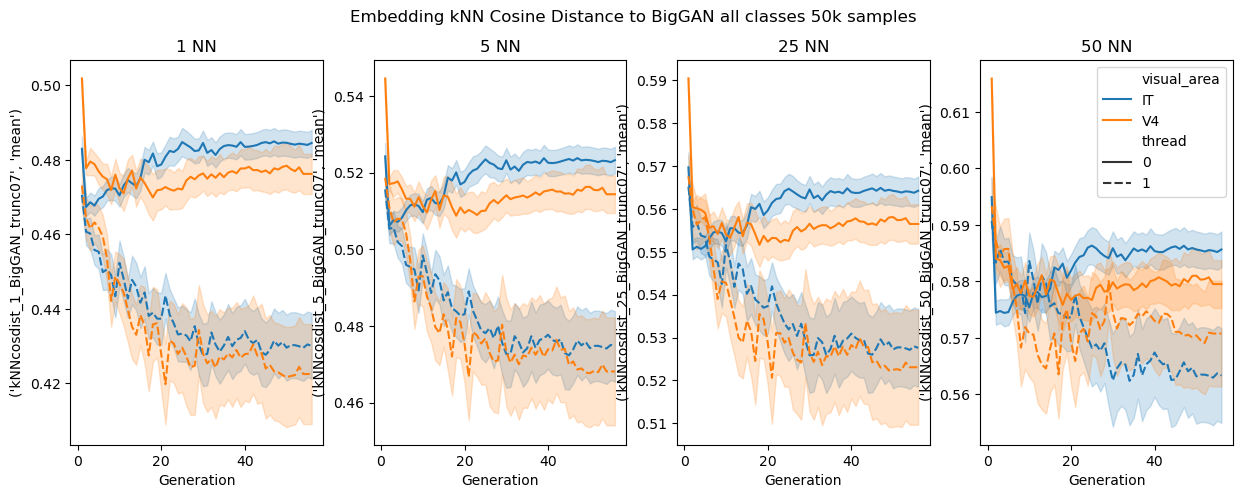

In [139]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
figh, axs = plt.subplots(1, 4, figsize=[15, 5],)
for ki, k in enumerate([1, 5, 25, 50]):
    sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
                x="generation", y=(f"kNNcosdist_{k}_BigGAN_trunc07","mean"), 
                style="thread",errorbar="se", hue="visual_area",  # ci=68, 
                hue_order=["IT", "V4"],
                n_boot=0, err_style="band", palette="tab10", ax=axs[ki],
                legend=True if ki==3 else False)
    axs[ki].set_xlabel("Generation")
    axs[ki].set_title(f"{k} NN")
plt.suptitle("Embedding kNN Cosine Distance to BigGAN all classes 50k samples")
plt.show()

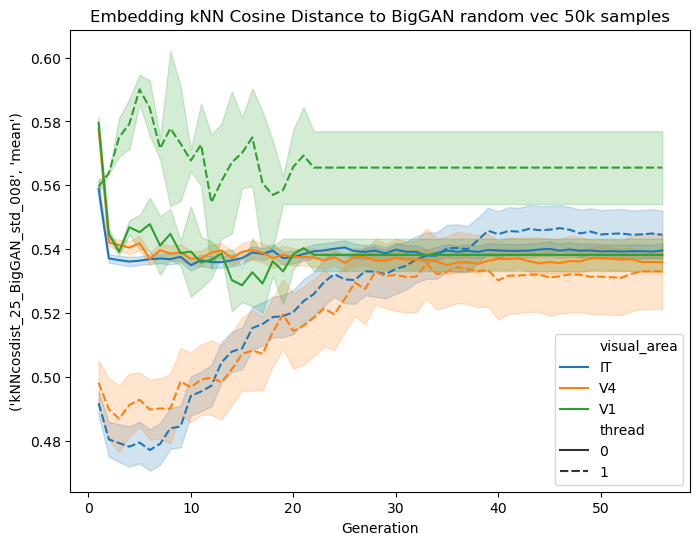

In [116]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
             x="generation", y=("kNNcosdist_25_BigGAN_std_008","mean"), 
             style="thread",errorbar="se", hue="visual_area",  # ci=68, 
             hue_order=["IT", "V4", "V1"],
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.title("Embedding kNN Cosine Distance to BigGAN random vec 50k samples")
plt.show()

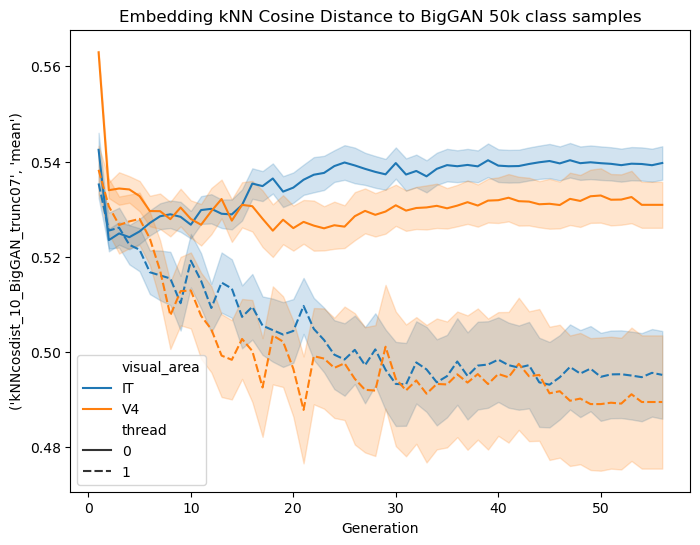

In [118]:
# plot the distance vs. generation 
Expi_masks = meta_df[validmsk & bothsucs_msk].index
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
             x="generation", y=("kNNcosdist_10_BigGAN_trunc07","mean"), 
             style="thread",errorbar="se", hue="visual_area",  # ci=68, 
             hue_order=["IT", "V4",],
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.title("Embedding kNN Cosine Distance to BigGAN 50k class samples")
plt.show()

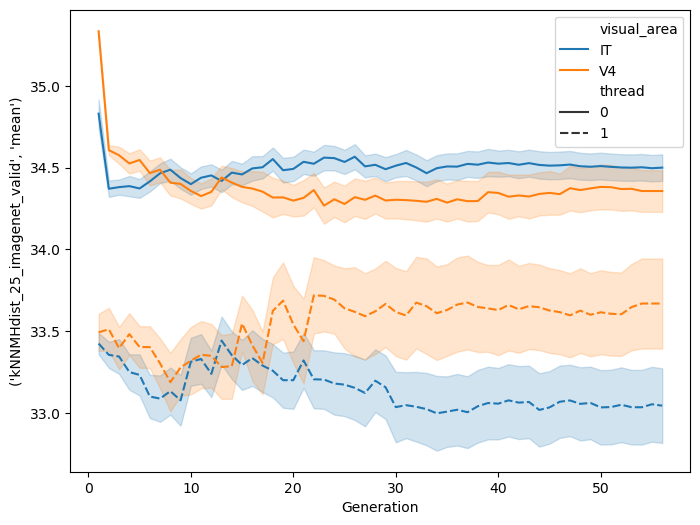

In [116]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_sum_df_extrap[stats_sum_df_extrap.Expi.isin(Expi_masks)], 
             x="generation", y=("kNNMHdist_25_imagenet_valid","mean"), 
             style="thread",errorbar="se", hue="visual_area",  # ci=68, 
             hue_order=["IT", "V4"],
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.show()

### Evol Trajectory Analysis (without extrap)

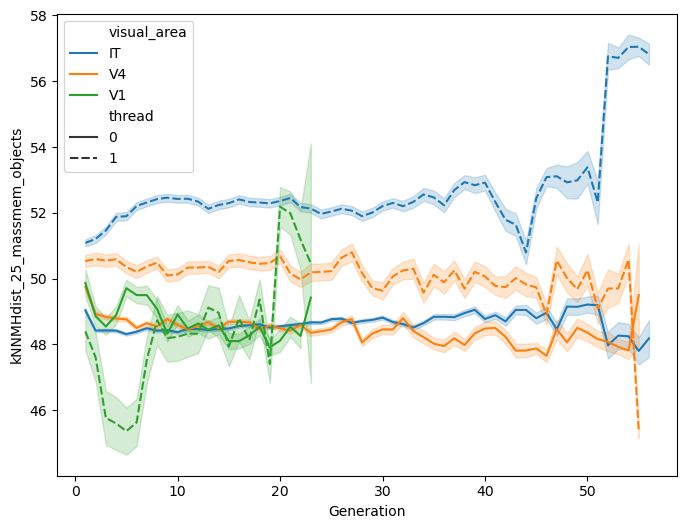

In [ ]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index

# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNMHdist_25_massmem_objects", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.show()

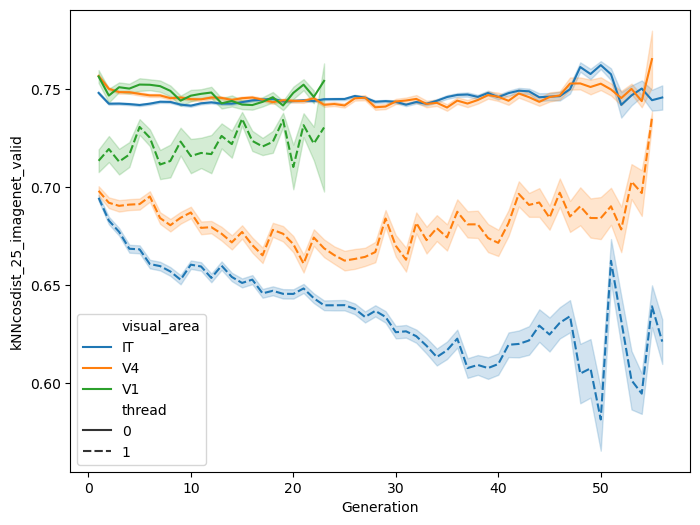

In [30]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index

# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNcosdist_25_imagenet_valid", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.show()

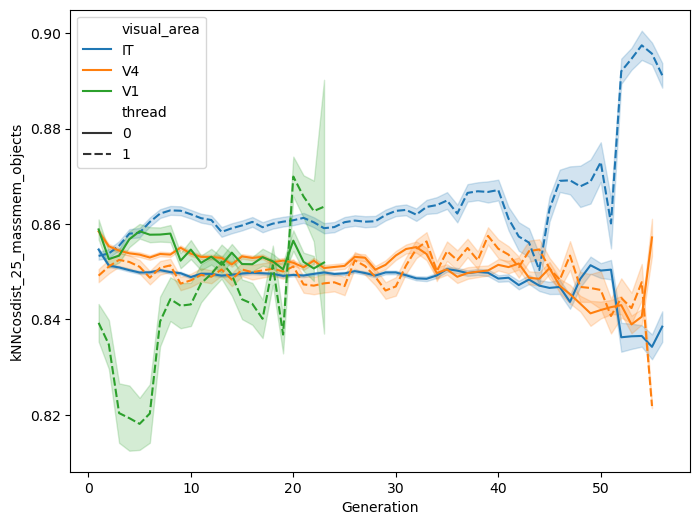

In [31]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index

# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNcosdist_25_massmem_objects", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.show()

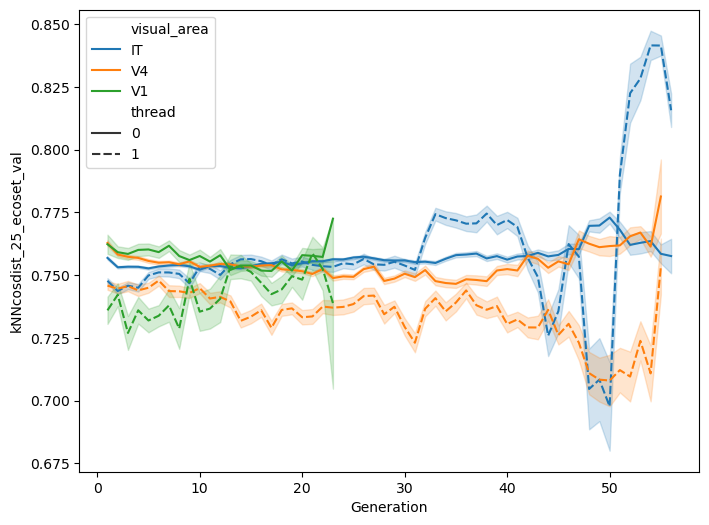

In [33]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index

# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNcosdist_25_ecoset_val", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.show()

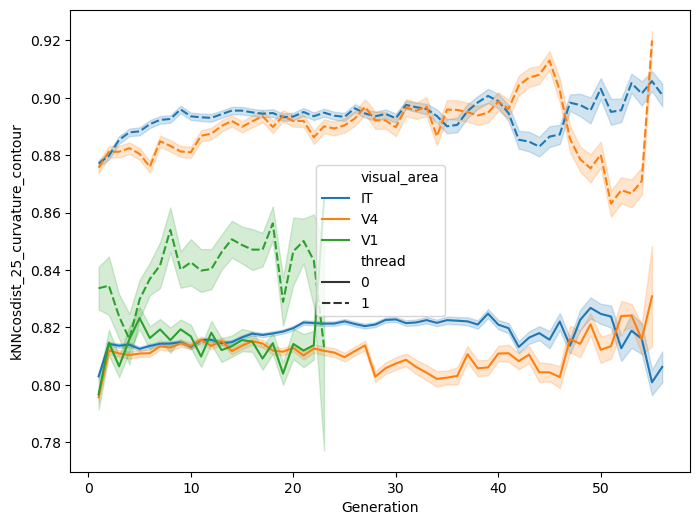

In [35]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index

# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNcosdist_25_curvature_contour", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.show()

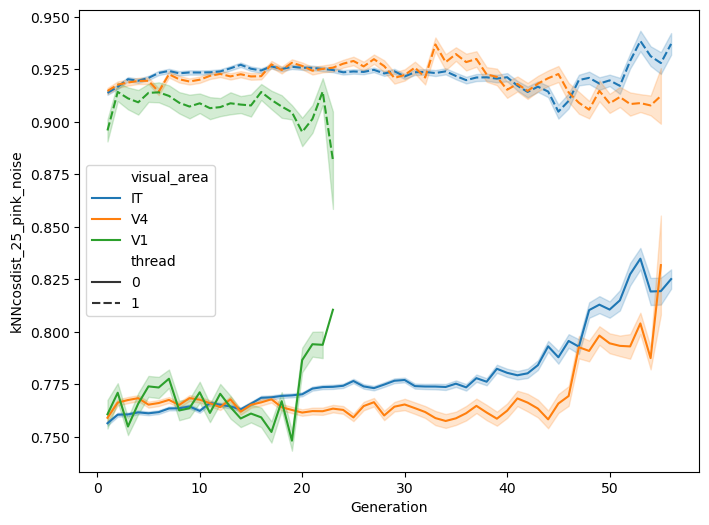

In [36]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index

# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNcosdist_25_pink_noise", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.show()

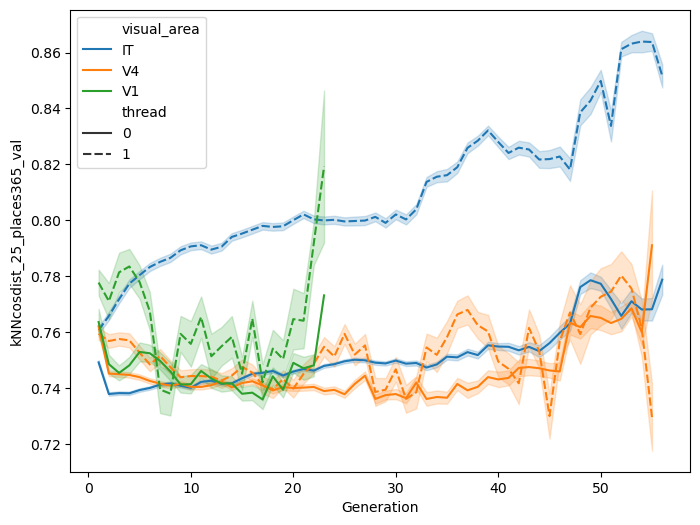

In [32]:
Expi_masks = meta_df[validmsk & bothsucs_msk].index

# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNcosdist_25_places365_val", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")
plt.show()

Text(0.5, 0, 'Generation')

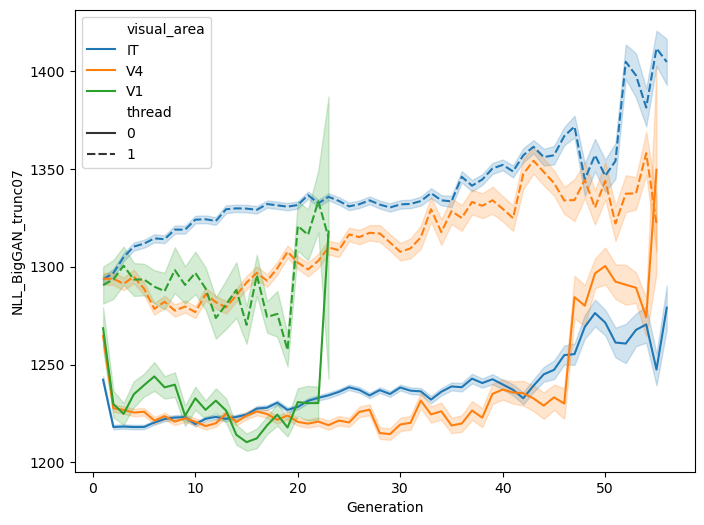

In [54]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="NLL_BigGAN_trunc07", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

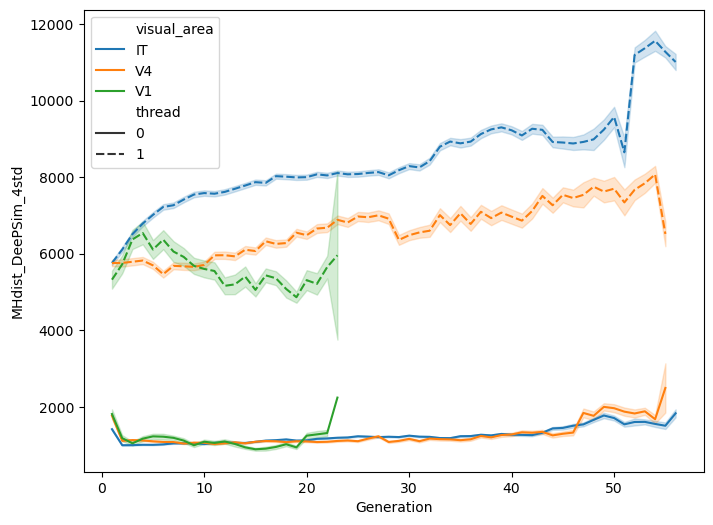

In [32]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_DeePSim_4std", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

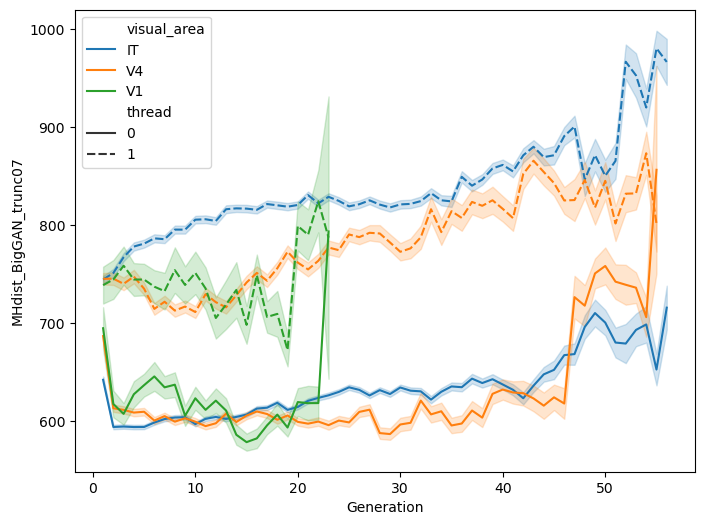

In [30]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_BigGAN_trunc07", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

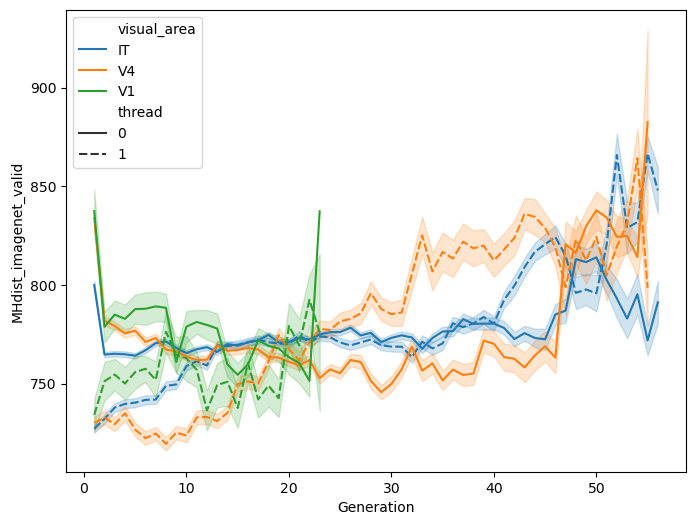

In [29]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_imagenet_valid", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

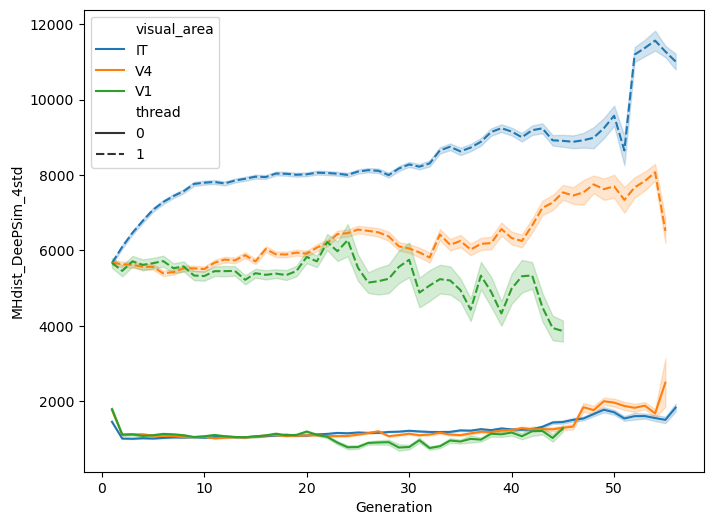

In [23]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_DeePSim_4std", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

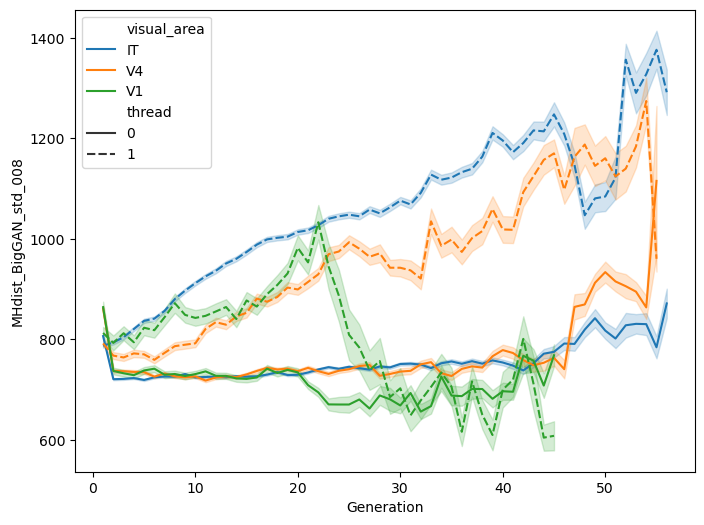

In [25]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_BigGAN_std_008", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

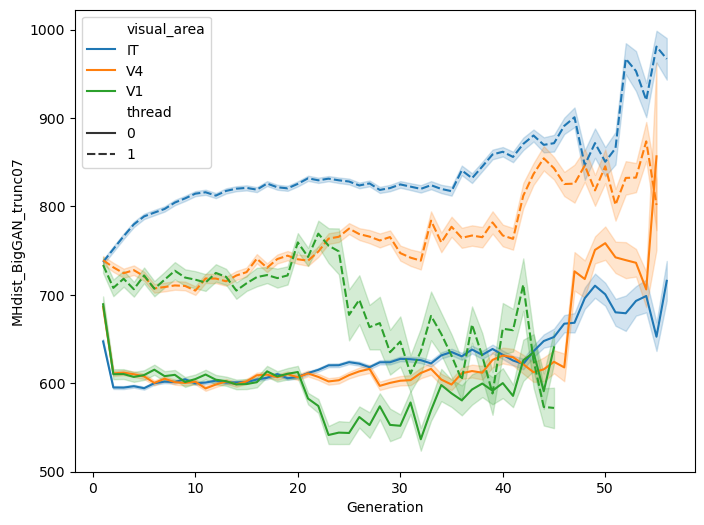

In [24]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="MHdist_BigGAN_trunc07", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

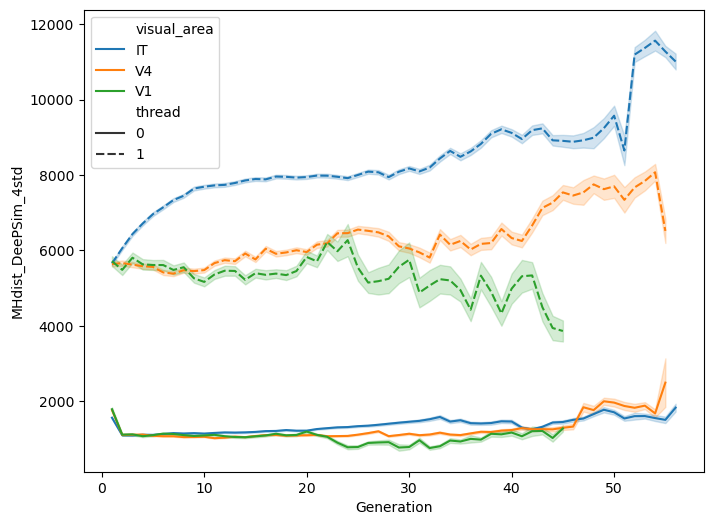

In [22]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all, x="generation", y="MHdist_DeePSim_4std", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

In [ ]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNMHdist_25_BigGAN_trunc07",
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

Text(0.5, 0, 'Generation')

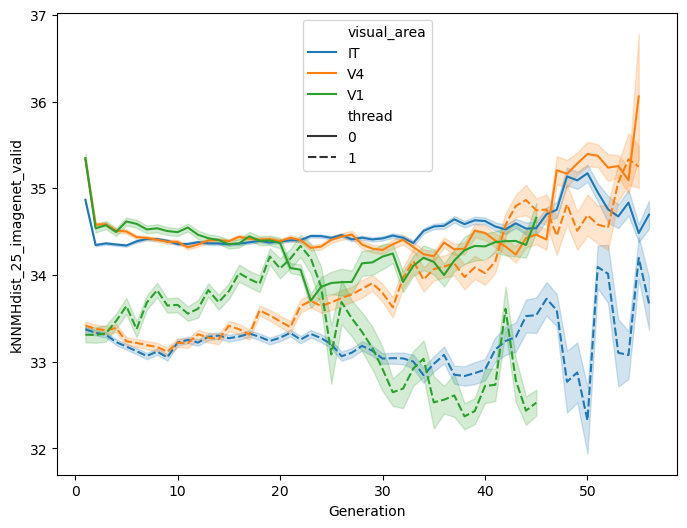

In [106]:
# plot the distance vs. generation 
plt.figure(figsize=[8, 6])
sns.lineplot(data=stats_df_all[stats_df_all.Expi.isin(Expi_masks)], 
             x="generation", y="kNNMHdist_25_imagenet_valid", 
             hue="visual_area", style="thread",errorbar="se", # ci=68, 
             n_boot=0, err_style="band", palette="tab10")
plt.xlabel("Generation")

## Single Session Analysis Demo

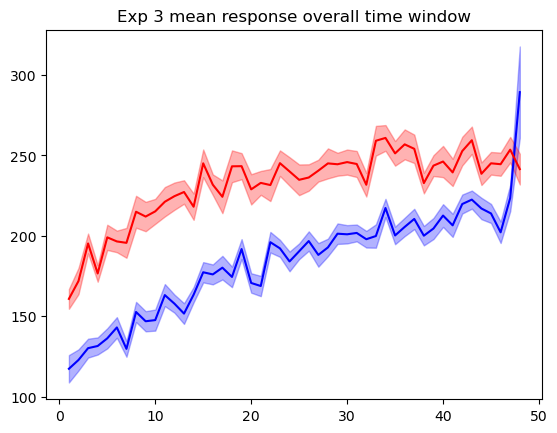

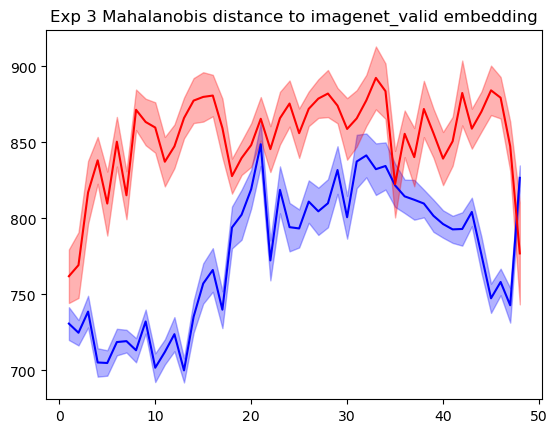

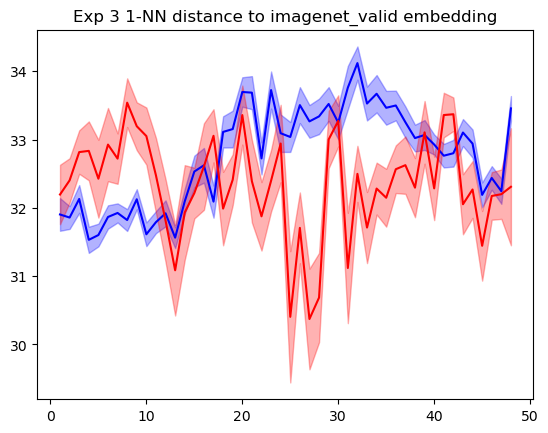

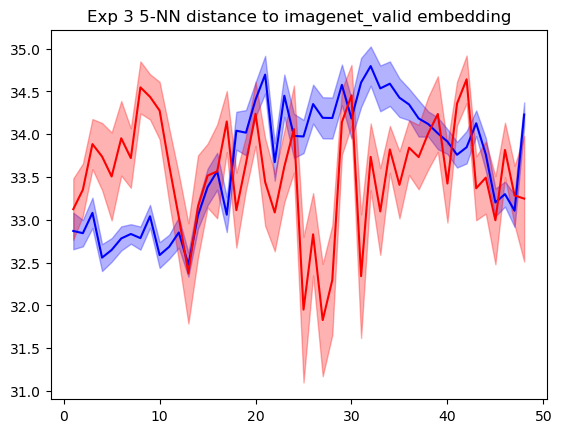

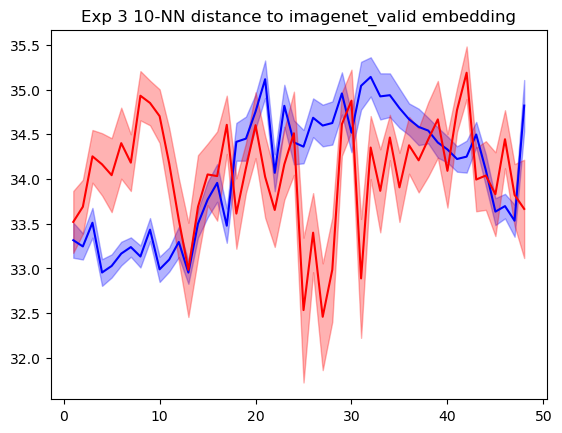

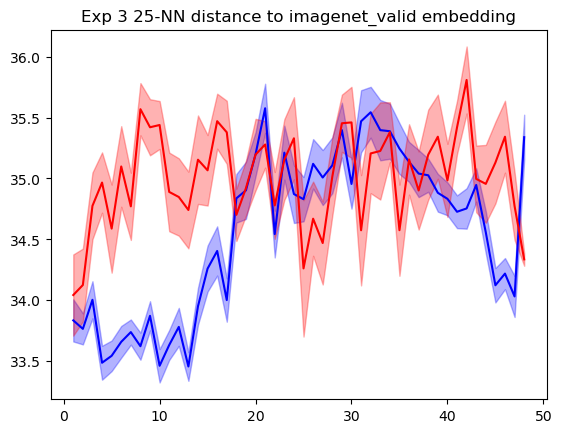

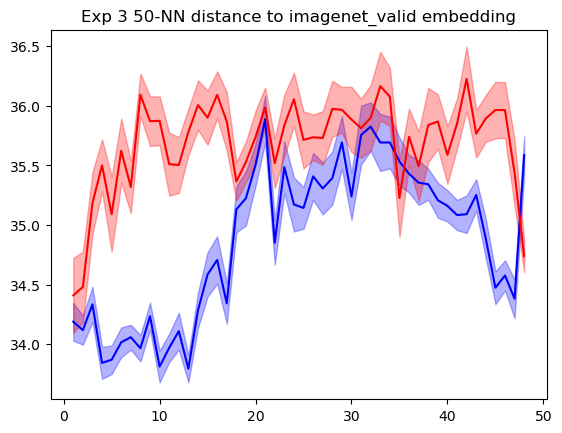

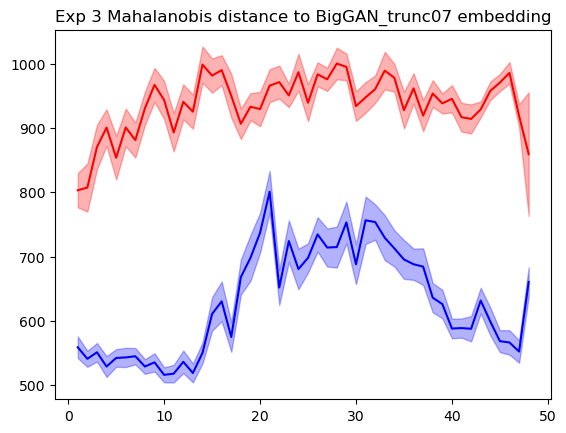

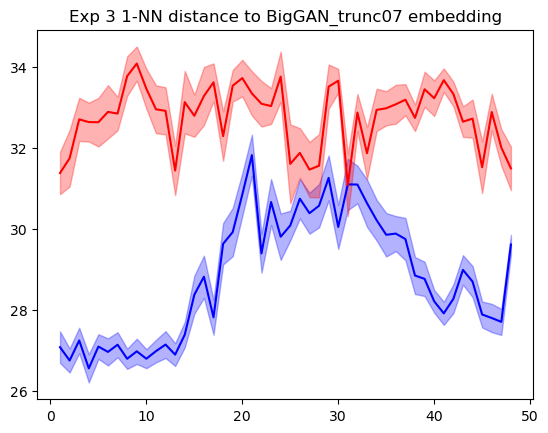

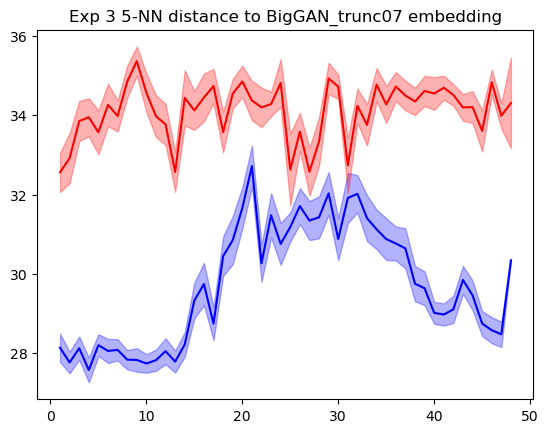

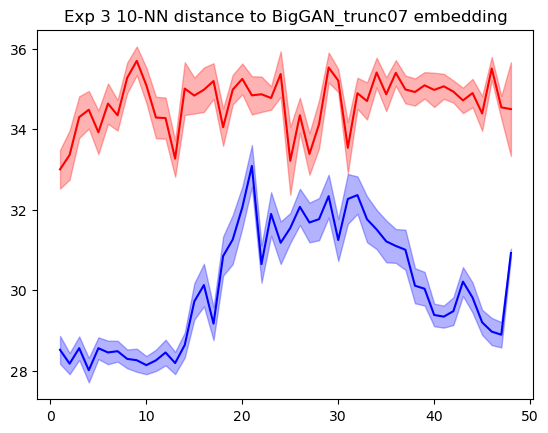

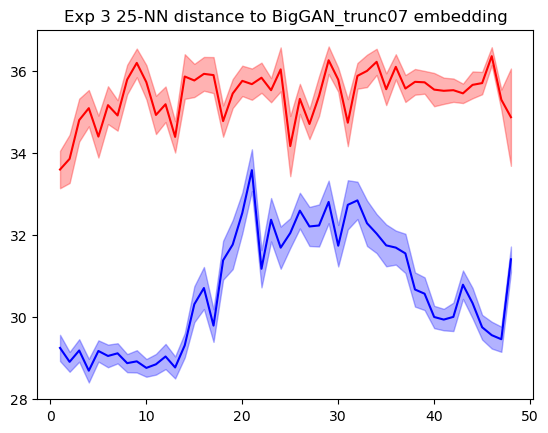

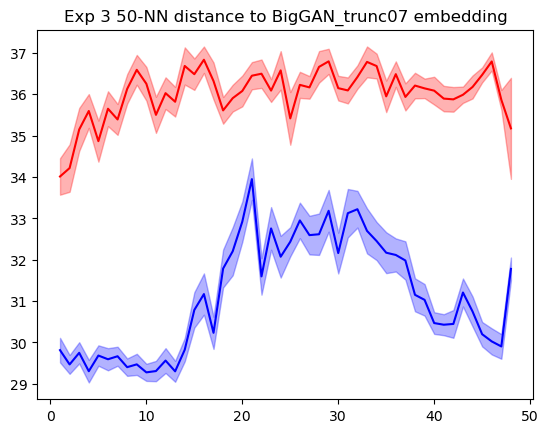

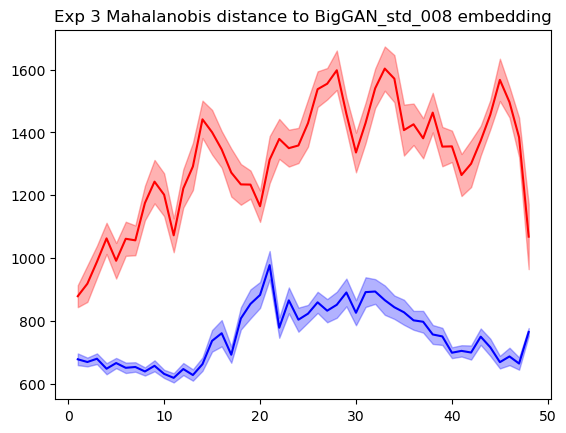

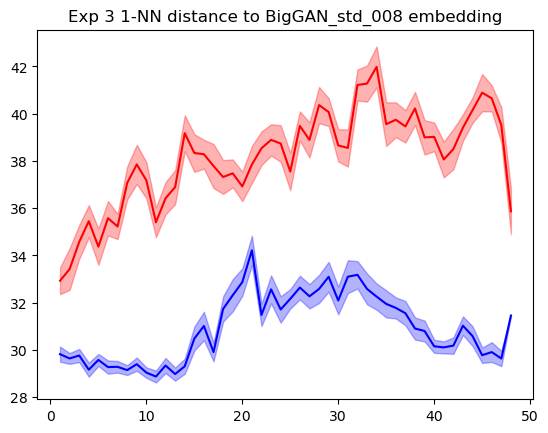

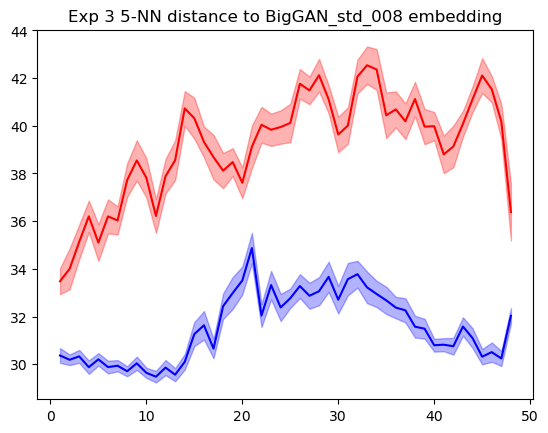

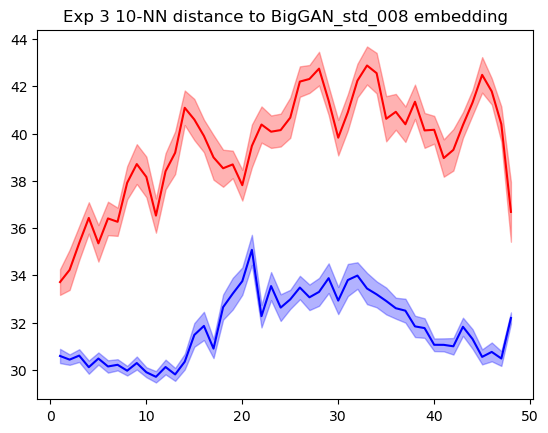

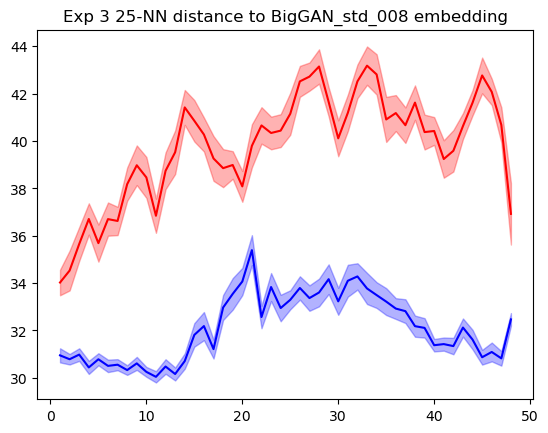

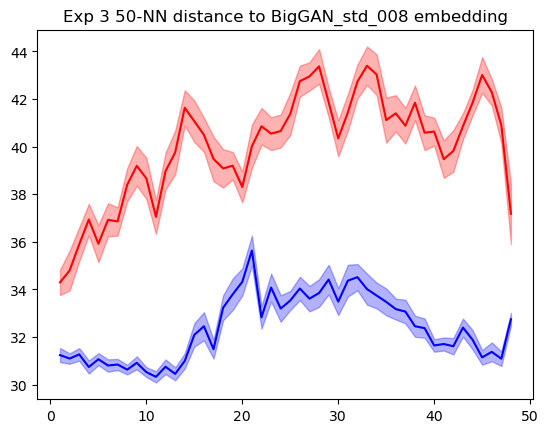

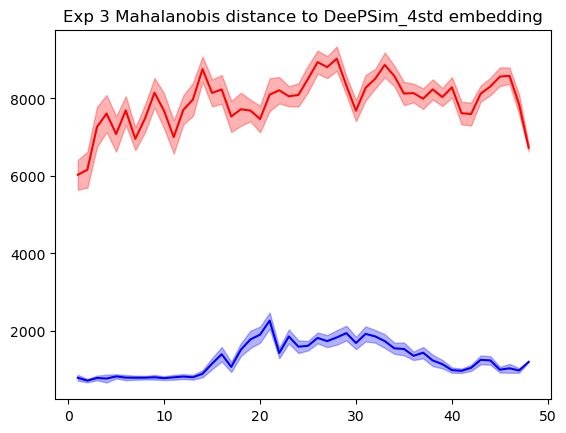

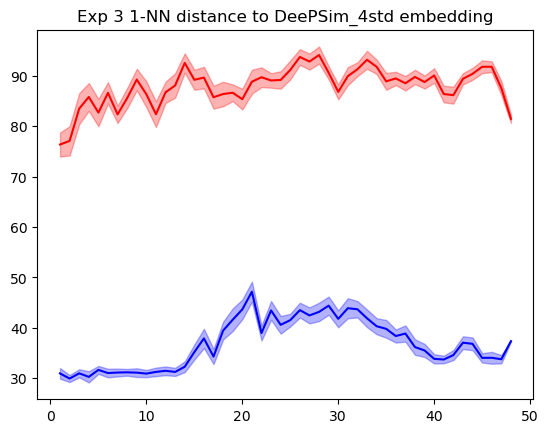

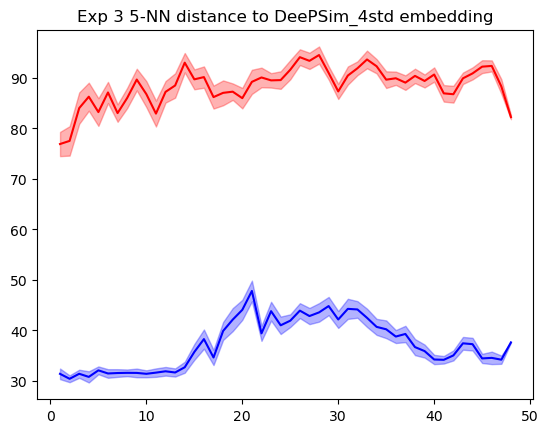

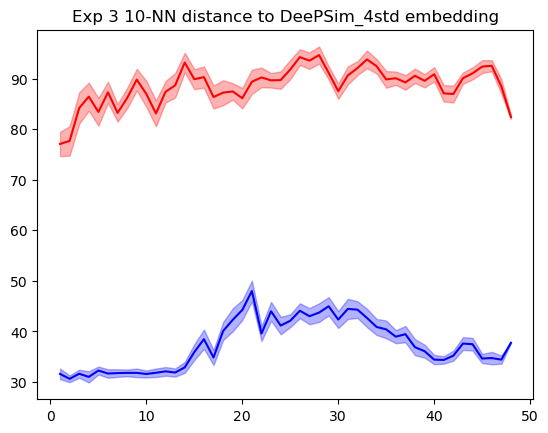

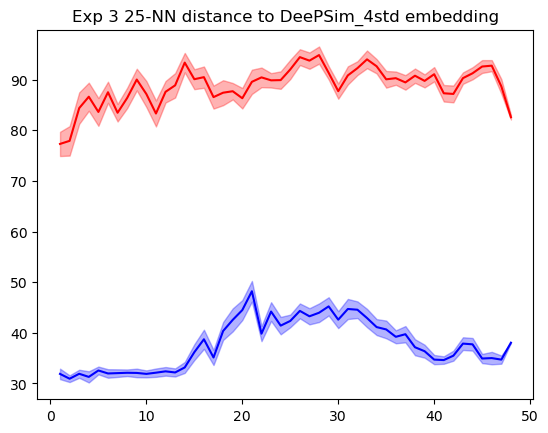

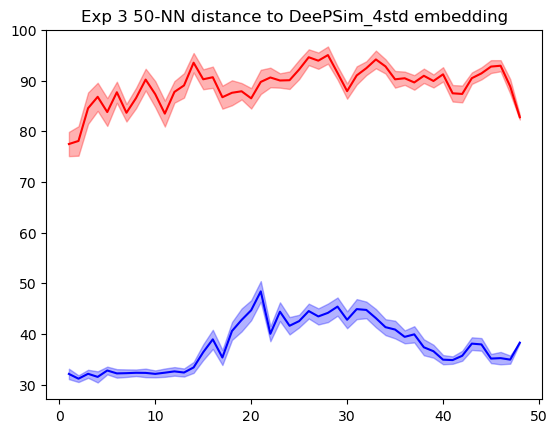

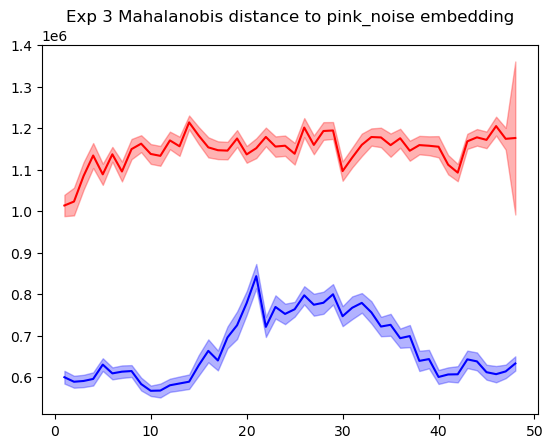

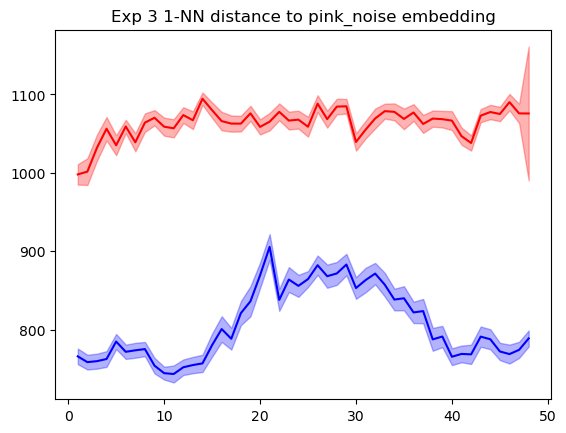

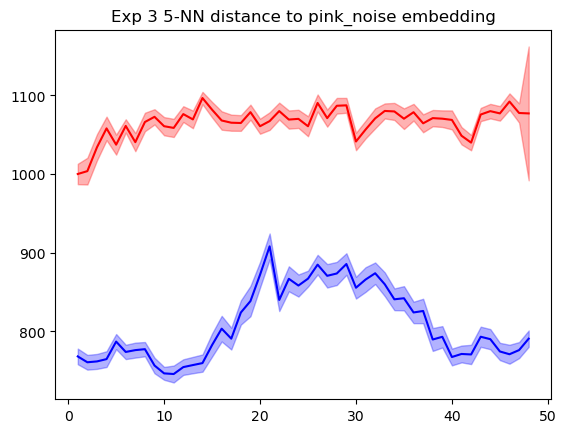

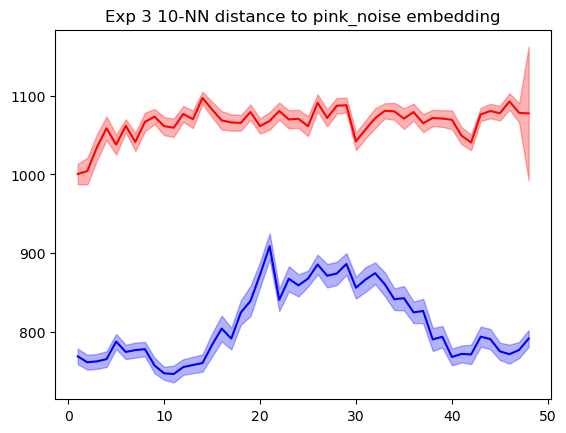

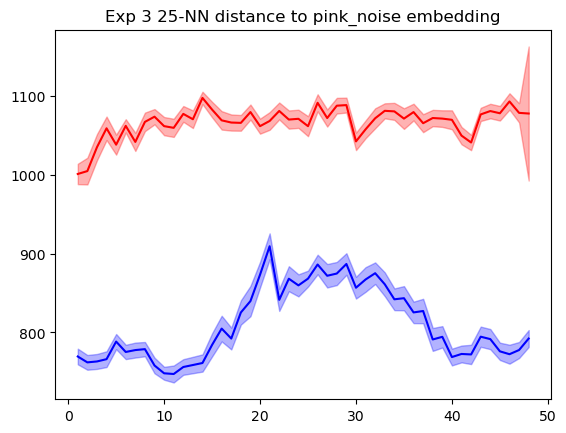

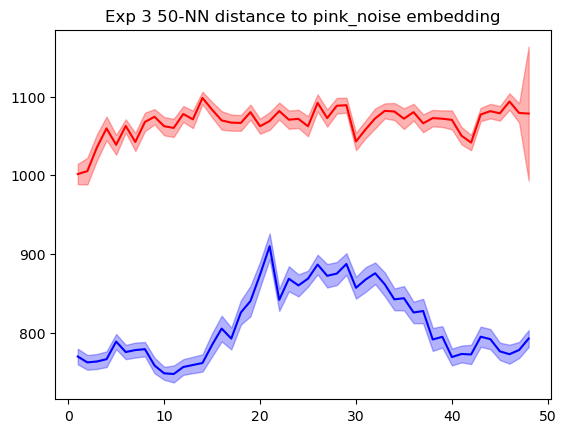

In [60]:
# Expi = 184
for Expi in [3]:#tqdm(range(1, 190+1)):
    # if ~ os.path.exists(join(Evol_embed_dir, f"Exp{Expi}_embed_act_data.pkl")):
    #     continue
    Evol_data = pkl.load(open(join(Evol_embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "rb"))
    embeddings0 = Evol_data["embeddings0"]
    embeddings1 = Evol_data["embeddings1"]
    imgfps0 = Evol_data["imgfps0"]
    imgfps1 = Evol_data["imgfps1"]
    resp_mat0 = Evol_data["resp_mat0"]
    resp_mat1 = Evol_data["resp_mat1"]
    gen_vec0 = Evol_data["gen_vec0"]
    gen_vec1 = Evol_data["gen_vec1"]
    plt.figure()
    plot_shaded_errorbar(gen_vec0, resp_mat0[:, 0], color="b", label="thread 0", var="sem")
    plot_shaded_errorbar(gen_vec1, resp_mat1[:, 0], color="r", label="thread 1", var="sem")
    plt.title(f"Exp {Expi} mean response overall time window")
    plt.show()
    for dataset_str in MH_eig_col:
        data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
        dataset_embed = load_dataset_embed(dataset_str)
        MHdist_0 = mahalanobis_sqdist(embeddings0.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
        MHdist_1 = mahalanobis_sqdist(embeddings1.cuda(), data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
        kNNdist_0 = dist2k_nearest_neighbor(embeddings0, dataset_embed, k_list=[1, 5, 10, 25, 50])
        kNNdist_1 = dist2k_nearest_neighbor(embeddings1, dataset_embed, k_list=[1, 5, 10, 25, 50])
        kNNMHdist_0 = dist2k_nearest_neighbor_mahalanobis(embeddings0, dataset_embed, [1, 5, 10, 25, 50],
                                                            data_eigvecs, data_eigvals, eigfloor=1e-3)
        kNNMHdist_1 = dist2k_nearest_neighbor_mahalanobis(embeddings1, dataset_embed, [1, 5, 10, 25, 50],
                                                            data_eigvecs, data_eigvals, eigfloor=1e-3)
        # raise Exception("Stop here")
        # Evol_data[f"MHdist_{dataset_str}_0"] = MHdist_0
        # Evol_data[f"MHdist_{dataset_str}_1"] = MHdist_1
        plt.figure()
        plot_shaded_errorbar(gen_vec0, MHdist_0, color="b", label="thread 0", var="sem")
        plot_shaded_errorbar(gen_vec1, MHdist_1, color="r", label="thread 1", var="sem")
        plt.title(f"Exp {Expi} Mahalanobis distance to {dataset_str} embedding")
        plt.show()
        for knn_k in [1, 5, 10, 25, 50]:
            plt.figure()
            plot_shaded_errorbar(gen_vec0, kNNMHdist_0[knn_k], color="b", label="thread 0", var="sem")
            plot_shaded_errorbar(gen_vec1, kNNMHdist_1[knn_k], color="r", label="thread 1", var="sem")
            plt.title(f"Exp {Expi} {knn_k}-NN Mahalanobis distance to {dataset_str} embedding")
            plt.show()
        # for knn_k in [1, 5, 10, 25, 50]:
        #     plt.figure()
        #     plot_shaded_errorbar(gen_vec0, kNNdist_0[knn_k], color="b", label="thread 0", var="sem")
        #     plot_shaded_errorbar(gen_vec1, kNNdist_1[knn_k], color="r", label="thread 1", var="sem")
        #     plt.title(f"Exp {Expi} {knn_k}-NN distance to {dataset_str} embedding")
        #     plt.show()


In [21]:
kNNdist_0[5].shape

torch.Size([910])

In [19]:
kNNdist_0[5].shape

torch.Size([438, 5])

In [12]:
dists = torch.cdist(embeddings0.cuda(), dataset_embed.cuda(),
                    p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
k_nearest = torch.topk(dists, 10, largest=False).values


In [13]:
k_nearest.shape

torch.Size([438, 10])

In [13]:
dists.shape

torch.Size([438, 50000])

In [17]:
torch.topk(dists, 20, largest=False, dim=-1).values

tensor([[26.1138, 26.2298, 26.2471,  ..., 27.3295, 27.3633, 27.3827],
        [27.0649, 27.2546, 27.3958,  ..., 29.0228, 29.0384, 29.0654],
        [26.7030, 26.8359, 27.3878,  ..., 28.1017, 28.1434, 28.1571],
        ...,
        [34.5442, 34.8168, 35.4651,  ..., 36.1671, 36.1725, 36.2736],
        [29.8034, 30.0843, 30.2442,  ..., 31.2762, 31.2865, 31.3019],
        [25.8355, 26.4108, 26.8948,  ..., 27.4858, 27.5396, 27.5504]],
       device='cuda:0')

In [18]:
torch.topk(dists, 30, largest=False, dim=-1).values

tensor([[26.1138, 26.2298, 26.2471,  ..., 27.5426, 27.5535, 27.5644],
        [27.0649, 27.2546, 27.3958,  ..., 29.1774, 29.1983, 29.2107],
        [26.7030, 26.8359, 27.3878,  ..., 28.2906, 28.3421, 28.3497],
        ...,
        [34.5442, 34.8168, 35.4651,  ..., 36.4511, 36.4523, 36.4701],
        [29.8034, 30.0843, 30.2442,  ..., 31.5507, 31.6468, 31.7481],
        [25.8355, 26.4108, 26.8948,  ..., 27.7769, 27.7984, 27.8077]],
       device='cuda:0')